This Python code uses pandas in Google Colab to load data from an Excel file, create new columns based on existing data, rename columns, and generate a new DataFrame with selected columns.

In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive to /content/drive
# This allows access to files stored in the user's Google Drive
drive.mount('/content/drive')

# Define the path to the Excel file and the name of the sheet to be read
# 'filename' stores the location of the Excel file within Google Drive
# 'Sheet_DatosRegion' stores the name of the specific sheet inside the Excel file that contains the data
filename = '/content/drive/My Drive/Colab Notebooks/Notebooks/Base Demanda Diaria 2017 2023.xlsx'
Sheet_DatosRegion = 'Datos Región'

# Read the Excel file and load the data into a Pandas DataFrame
# 'pd.read_excel()' is used to read data from an Excel file
# The 'filename' variable specifies the file to read
# The 'sheet_name' parameter is set to 'Sheet_DatosRegion' to select the correct sheet
# The resulting DataFrame 'df' now holds the data from the specified Excel sheet
df = pd.read_excel(filename, sheet_name=Sheet_DatosRegion)

# Add a new column 'Tipo_dia_valor' to the DataFrame 'df'
# This column assigns numerical values based on the content of the 'Tipo día' column:
# - 1 if the 'Tipo día' column contains the word 'feriado' (case-insensitive)
# - 2 if the 'Tipo día' column contains the word 'semilaborable' (case-insensitive)
# - 0 for any other case
# The '.apply()' method is used to apply a lambda function to each element of the 'Tipo día' column
# The lambda function checks for the presence of the specified words using the 'in' operator and the '.lower()' method for case-insensitive comparison
df['Tipo_dia_valor'] = df['Tipo día'].apply(lambda x: 1 if 'feriado' in x.lower() else 2 if 'semilaborable' in x.lower() else 0)

# Add a new column 'MES_NUM' to the DataFrame 'df'
# This column extracts the month number from the 'MES' column after converting it to datetime objects
# 'pd.to_datetime()' converts the 'MES' column to datetime objects using the specified format '%d-%m-%Y'
# '.dt.month' then extracts the month number as an integer
# This assumes that the 'MES' column contains date information
df['MES_NUM'] = pd.to_datetime(df['MES'], format='%d-%m-%Y').dt.month

# Rename the columns 'GRAN BS.AS.' to 'Demanda_Diaria' and 'TEMPERATURA REFERENCIA MEDIA GBA °C' to 'TEMPERATURA_MEDIA'
# The '.rename()' method is used to change the names of the columns
# The 'columns' parameter takes a dictionary where keys are the old names and values are the new names
# This improves the readability and clarity of the DataFrame by using more descriptive column names
df = df.rename(columns={'GRAN BS.AS.': 'Demanda_Diaria'})
df = df.rename(columns={'TEMPERATURA REFERENCIA MEDIA GBA °C': 'TEMPERATURA_MEDIA'})

# Create a new DataFrame 'df_procesado' containing only the columns of interest
# This new DataFrame is a subset of the original DataFrame 'df'
# It includes only the columns that are relevant for further analysis or processing
# The selected columns are: 'AÑO', 'Fecha', 'MES_NUM', 'Tipo_dia_valor', 'TEMPERATURA_MEDIA', and 'Demanda_Diaria'
# This step helps to focus on the necessary data and discard unnecessary information
df_procesado = df[['AÑO', 'Fecha', 'MES_NUM', 'Tipo_dia_valor', 'TEMPERATURA_MEDIA', 'Demanda_Diaria']]

Mounted at /content/drive


# SARIMA Model

This Python code snippet performs time series forecasting using the SARIMAX model. It iteratively trains and evaluates the model on a rolling window of the input data (df_procesado).

The code first initializes variables to store error metrics and control the loop. The while loop continues until a certain percentage (15%) of the original data remains. Inside the loop, the data is split into training (80%) and testing (20%) sets. A SARIMAX model is then fitted to the training data, and predictions are made on the test data. Error metrics (MSE, RMSE, MAE, MAPE) are calculated and accumulated.  The training window is then moved forward by reducing the longitud_df_procesado variable and the process repeats. Finally, the average error metrics across all iterations are calculated and printed. The time.sleep(5) line introduces a 5-second pause in each iteration, likely for rate limiting or other operational reasons.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from google.colab import drive
import pandas as pd
from math import sqrt
import time

# Get the total size of the processed DataFrame
longitud_df_procesado = len(df_procesado)

# Define the limit length, which is 15% of the total dataset size
longitud_limite = longitud_df_procesado * 0.15

# Initialize variables to store iteration counts, test data, and lists for SARIMA error metrics
iteraciones = 0
test_data = []
list_sarima_mse = []
list_sarima_rmse = []
list_sarima_mae = []
list_sarima_mape = []
sarima_mse = 0
sarima_rmse = 0
sarima_mae = 0
sarima_mape = 0

# Loop until the processed DataFrame length is less than the defined limit
while not(longitud_df_procesado < longitud_limite):

    # Set the total data size for the current iteration
    Total_datos = longitud_df_procesado

    # Select data from the beginning of the processed DataFrame up to Total_datos
    endog = df_procesado.head(Total_datos)

    # Split the data into training and testing sets (80% for training, 20% for testing)
    train_data = endog[:int(0.8 * Total_datos)]
    test_data = endog[int(0.8 * Total_datos):]

    # Fit the SARIMAX model to the training data
    # Model parameters: order=(2, 0, 2), seasonal_order=(0, 0, 2, 6), enforce_stationarity=False, enforce_invertibility=False
    model = SARIMAX(endog['Demanda_Diaria'], order=(2, 0, 2), seasonal_order=(0, 0, 2, 6), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()

    # Generate predictions on the test set
    predictions = results.predict(start=len(train_data), end=Total_datos-1)

    # Accumulate error metrics (MSE, RMSE, MAE, MAPE)
    sarima_mse = sarima_mse + mean_squared_error(test_data['Demanda_Diaria'], predictions)
    sarima_rmse = sarima_rmse + sqrt(mean_squared_error(test_data['Demanda_Diaria'], predictions))
    sarima_mae = sarima_mae + mean_absolute_error(test_data['Demanda_Diaria'], predictions)
    sarima_mape = sarima_mape + mean_absolute_percentage_error(test_data['Demanda_Diaria'], predictions)

    # Append error metrics for the current iteration to their respective lists
    list_sarima_mse.append(mean_squared_error(test_data['Demanda_Diaria'], predictions))
    list_sarima_rmse.append(sqrt(mean_squared_error(test_data['Demanda_Diaria'], predictions))
    list_sarima_mae.append(mean_absolute_error(test_data['Demanda_Diaria'], predictions))
    list_sarima_mape.append(mean_absolute_percentage_error(test_data['Demanda_Diaria'], predictions))

    # Reduce the processed DataFrame length by the size of the test data (effectively moving the training window)
    longitud_df_procesado = longitud_df_procesado - len(test_data)

    # Increment the iteration counter
    iteraciones = iteraciones + 1

    # Pause execution for 5 seconds (likely for rate limiting or other purposes)
    time.sleep(5)

# Calculate the average error metrics over all iterations
sarima_mse = (sarima_mse/iteraciones)
sarima_rmse = (sarima_rmse/iteraciones)
sarima_mae = (sarima_mae/iteraciones)
sarima_mape = (sarima_mape/iteraciones)

# Store the predictions (it seems 'predictions' was already available, so this might be redundant)
sarima_pred = predictions

# Print the calculated error metrics
print('Mean Squared Error: %.1f' % sarima_mse)
print('Root Mean Squared Error: %.1f' % sarima_rmse)
print('Mean Absolute Error: %.1f' % sarima_mae)
print('Mean Absolute Percentage Error: %.1f%%' % (sarima_mape * 100))

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Error cuadrático medio: 284388.1
Raiz cuadrada del error cuadrático medio: 527.6
Error absoluto medio: 417.1
Error porcentual medio absoluto: 7.4%


This Python code snippet implements a SARIMA (Seasonal Autoregressive Integrated Moving Average with eXogenous regressors) time series model. It reads data, likely from a pre-existing DataFrame (df_procesado), splits it into training and test sets, fits a SARIMAX model, makes predictions, evaluates the model's performance using error metrics, and finally visualizes the training data, test data, and model predictions.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error cuadrático medio: 294028.5
Raiz cuadrada del error cuadrático medio: 542.2
Error absoluto medio: 418.2
Error porcentual medio absoluto: 7.2%


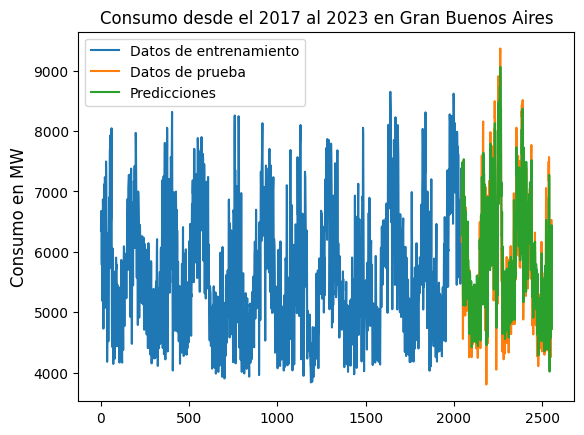

In [ ]:
# Implement a SARIMA model using the processed DataFrame
import matplotlib.pyplot as plt  # Import the matplotlib.pyplot library for plotting
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Import the SARIMAX class from statsmodels for SARIMA modeling
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  # Import metrics for evaluating model performance
from google.colab import drive  # Import the google.colab.drive module to mount Google Drive
import pandas as pd  # Import the pandas library for data manipulation
from math import sqrt  # Import the sqrt function for calculating the square root

# Initialize 'grid' variable (its purpose is unclear from this snippet, but it might be related to a grid search, though not implemented here)
grid = 0

# Calculate 'Total_datos' (total data points) by subtracting 'grid' from the length of the processed DataFrame
Total_datos = len(df_procesado) - grid

# Create 'endog' DataFrame, taking the first 'Total_datos' rows from the processed DataFrame
endog = df_procesado.head(Total_datos)

# Split the dataset into training and testing sets
# 'train_data' contains the first 80% of 'endog'
# 'test_data' contains the remaining 20% of 'endog'
train_data = endog[:int(0.8 * Total_datos)]
test_data = endog[int(0.8 * Total_datos):]

# Fit the SARIMAX model to the training data
# Model parameters:
#   - order=(2, 0, 2): ARIMA order (p, d, q)
#   - seasonal_order=(0, 0, 2, 6): Seasonal ARIMA order (P, D, Q, S) where S is the seasonal period
#   - enforce_stationarity=False, enforce_invertibility=False: Relax stationarity and invertibility constraints
# 'Demanda_Diaria' is the endogenous variable (the time series being modeled)
model = SARIMAX(endog['Demanda_Diaria'], order=(2, 0, 2), seasonal_order=(0, 0, 2, 6), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()  # Fit the SARIMAX model

# Make predictions on the test set
# 'predictions' contains the model's predictions for the time period covered by 'test_data'
predictions = results.predict(start=len(train_data), end=Total_datos-1)

# Calculate Mean Squared Error (MSE) between the actual test data and the predictions
sarima_mse = mean_squared_error(test_data['Demanda_Diaria'], predictions)
print('Mean Squared Error: %.1f' % sarima_mse)  # Print the MSE

# Calculate Root Mean Squared Error (RMSE) by taking the square root of the MSE
sarima_rmse = sqrt(mean_squared_error(test_data['Demanda_Diaria'], predictions))
print('Root Mean Squared Error: %.1f' % sarima_rmse)  # Print the RMSE

# Calculate Mean Absolute Error (MAE)
sarima_mae = mean_absolute_error(test_data['Demanda_Diaria'], predictions)
print('Mean Absolute Error: %.1f' % sarima_mae)  # Print the MAE

# Calculate Mean Absolute Percentage Error (MAPE)
sarima_mape = mean_absolute_percentage_error(test_data['Demanda_Diaria'], predictions)
print('Mean Absolute Percentage Error: %.1f%%' % (sarima_mape * 100))  # Print the MAPE

# Plot the training data, test data, and predictions
plt.plot(subplots=True, figsize=(15, 8), fontsize=12)  # Create a plot with specified figure size and font size
plt.title("Consumo desde el 2017 al 2023 en Gran Buenos Aires")  # Set the title of the plot
plt.plot(train_data['Demanda_Diaria'], label='Training Data')  # Plot the training data
plt.plot(test_data['Demanda_Diaria'], label='Test Data')  # Plot the test data
plt.plot(predictions, label='Predictions')  # Plot the predictions
plt.ylabel('Consumo en MW', fontsize=12)  # Set the y-axis label
plt.legend()  # Display the legend
plt.show()  # Show the plot

# SVM Model

This Python code snippet implements a Support Vector Regression (SVR) model for time series forecasting. It appears to be designed for a rolling window prediction approach.

The code first imports necessary libraries. It initializes variables for tracking the size of the data, error metrics, and iteration counts.  The core logic resides within a while loop that continues until a certain percentage (15%) of the data remains. Inside the loop, the data is split into training (80%) and testing (20%) sets. The 'Demanda_Diaria' column is extracted, and MinMaxScaler is used to scale the training and test sets. The data is then transformed into sequences of length 'timesteps' to be used as input for the SVR model. An SVR model is initialized and trained on the training data.  Predictions are made on both the training and test sets, and these predictions are then inverse-transformed to the original scale. Error metrics (MSE, RMSE, MAE, MAPE) are calculated and accumulated.  The training window is shifted by reducing longitud_df_procesado, and the process repeats. Finally, the average error metrics are calculated and printed.

Source: https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md.

In [ ]:
import os  # Import the os module for operating system dependent functionality (not directly used in the provided snippet)
import warnings  # Import the warnings module to handle warnings (not directly used in the provided snippet)
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting (not directly used in the provided snippet)
import numpy as np  # Import numpy for numerical operations and array manipulation
import pandas as pd  # Import pandas for data manipulation and analysis
import datetime as dt  # Import the datetime module (aliased as dt) for date and time operations (not directly used in the provided snippet)
import math  # Import the math module for mathematical functions

from sklearn.svm import SVR  # Import the Support Vector Regression model from scikit-learn
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler for scaling data
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  # Import metrics for evaluating model performance
from datetime import datetime, timedelta  # Import datetime and timedelta classes from the datetime module (not directly used in the provided snippet)
from math import sqrt  # Import the square root function

# Get the total size of the processed DataFrame
longitud_df_procesado = len(df_procesado)

# Define the limit length, which is 15% of the total dataset size
longitud_limite = longitud_df_procesado * 0.15

# Initialize variables to store iteration counts, test data, and lists for SVM error metrics
iteraciones = 0
test_data = []
list_svm_mse = []
list_svm_rmse = []
list_svm_mae = []
list_svm_mape = []
svm_mse = 0
svm_rmse = 0
svm_mae = 0
svm_mape = 0

# Loop until the processed DataFrame length is less than the defined limit
while not(longitud_df_procesado < longitud_limite):

    # Set the total data size for the current iteration
    Total_datos = longitud_df_procesado

    # Select data from the beginning of the processed DataFrame up to Total_datos
    endog = df_procesado.head(Total_datos)

    # Split the data into training and testing sets (80% for training, 20% for testing)
    train = endog[:int(0.8 * Total_datos)][['Demanda_Diaria']]
    test = endog[int(0.8 * Total_datos):][['Demanda_Diaria']]

    # Initialize a MinMaxScaler to scale the data
    scaler = MinMaxScaler()

    # Scale the training and testing data using MinMaxScaler
    train['Demanda_Diaria'] = scaler.fit_transform(train)  # Fit and transform the training data
    test['Demanda_Diaria'] = scaler.transform(test)  # Transform the testing data

    # Convert the training and testing DataFrames to NumPy arrays
    train_data = train.values
    test_data = test.values

    # Define the number of timesteps for the input sequences
    timesteps=5

    # Convert training data to 2D tensor using nested list comprehension
    # This creates input sequences of 'timesteps' length for the model
    train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
    # train_data_timesteps.shape  # This line is commented out, but it would show the shape of train_data_timesteps

    # Convert testing data to 2D tensor
    # This creates input sequences of 'timesteps' length for the model
    test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
    # test_data_timesteps.shape  # This line is commented out, but it would show the shape of test_data_timesteps

    # Selecting inputs and outputs from training and testing data
    # x_train and x_test contain the input sequences, y_train and y_test contain the corresponding target values (the value at the next timestep)
    x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
    x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

    # Initialize the Support Vector Regression (SVR) model
    # Model parameters: kernel='rbf', gamma=0.5, C=10, epsilon=0.05
    model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

    # Fit the model on training data
    model.fit(x_train, y_train[:,0])
    # SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)  # This line is commented out, but it shows the SVR parameters after fitting

    # Make model predictions on the training and testing sets
    y_train_pred = model.predict(x_train).reshape(-1,1)
    y_test_pred = model.predict(x_test).reshape(-1,1)

    # Inverse transform the predictions to the original scale
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)

    # Inverse transform the original target values to the original scale
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)

    # Calculate error metrics (MSE, RMSE, MAE, MAPE)
    svm_mse = svm_mse + mean_squared_error(y_test, y_test_pred)
    svm_rmse = svm_rmse + sqrt(mean_squared_error(y_test, y_test_pred))
    svm_mae = svm_mae + mean_absolute_error(y_test, y_test_pred)
    svm_mape = svm_mape + mean_absolute_percentage_error(y_test, y_test_pred)

    # Append error metrics for the current iteration to their respective lists
    list_svm_mse.append(mean_squared_error(y_test, y_test_pred))
    list_svm_rmse.append(sqrt(mean_squared_error(y_test, y_test_pred)))
    list_svm_mae.append(mean_absolute_error(y_test, y_test_pred))
    list_svm_mape.append(mean_absolute_percentage_error(y_test, y_test_pred))

    # Reduce the processed DataFrame length by the size of the test data (effectively moving the training window)
    longitud_df_procesado = longitud_df_procesado - len(test)

    # Increment the iteration counter
    iteraciones = iteraciones + 1

# Calculate the average error metrics over all iterations
svm_mse = (svm_mse/iteraciones)
svm_rmse = (svm_rmse/iteraciones)
svm_mae = (svm_mae/iteraciones)
svm_mape = (svm_mape/iteraciones)

# Store the predictions (it seems 'y_test_pred' was already available, so this might be redundant)
svm_pred = y_test_pred

# Print the calculated error metrics
print('Mean Squared Error: %.1f' % svm_mse)
print('Root Mean Squared Error: %.1f' % svm_rmse)
print('Mean Absolute Error: %.1f' % svm_mae)
print('Mean Absolute Percentage Error: %.1f%%' % (svm_mape * 100))

Error cuadrático medio: 292007.6
Raiz cuadrada del error cuadrático medio: 535.0
Error absoluto medio: 414.9
Error porcentual medio absoluto: 7.4%


# Instalación EMD

In [ ]:
! pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00


# Modelo CNN

This Python code snippet implements a 1D Convolutional Neural Network (CNN) model for time series forecasting.  It defines a function split_sequence to prepare the data for a supervised learning format, creating input sequences and corresponding output values.

The main part of the code initializes variables for tracking data size, error metrics, and iteration counts. It then enters a while loop that continues until a certain percentage (15%) of the original data remains. Inside the loop, it extracts time series data, prepares it into input sequences, splits the data into training and testing sets, defines and compiles a 1D CNN model, trains the model, makes predictions, calculates error metrics (MSE, RMSE, MAE, MAPE), and accumulates these metrics. The training window is effectively moved forward by reducing longitud_df_procesado, and the process repeats. Finally, the average error metrics across all iterations are calculated and printed.

In [ ]:
from keras.models import Sequential  # Import the Sequential model from Keras
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D  # Import necessary layers for building the CNN
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  # Import metrics for evaluating model performance
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting (not used in the provided snippet)
from numpy import array  # Import the array function from NumPy

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    # This function splits a univariate sequence into samples of specified length
    X, y = list(), list()  # Initialize empty lists to store input sequences (X) and output values (y)
    for i in range(len(sequence)):  # Iterate through the sequence
        # find the end of this pattern
        end_ix = i + n_steps  # Calculate the end index of the current pattern
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:  # Check if the end index exceeds the sequence length
            break  # If it does, break the loop
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]  # Extract the input sequence (seq_x) and the output value (seq_y)
        X.append(seq_x)  # Append the input sequence to the list X
        y.append(seq_y)  # Append the output value to the list y
    return array(X), array(y)  # Convert the lists X and y to NumPy arrays and return them

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)  # Get the total length of the processed DataFrame
# La longitud limite es hasta llegar al 15% del data set
longitud_limite = longitud_df_procesado * 0.15  # Calculate the limit length (15% of the DataFrame length)
# Inicialización de variables
iteraciones = 0  # Initialize iteration counter
test_data = []  # Initialize an empty list for test data (not used within the loop)
list_cnn_mse = []  # Initialize an empty list to store MSE values for each iteration
list_cnn_rmse = []  # Initialize an empty list to store RMSE values for each iteration
list_cnn_mae = []  # Initialize an empty list to store MAE values for each iteration
list_cnn_mape = []  # Initialize an empty list to store MAPE values for each iteration
cnn_mse = 0  # Initialize MSE accumulator
cnn_rmse = 0  # Initialize RMSE accumulator
cnn_mae = 0  # Initialize MAE accumulator
cnn_mape = 0  # Initialize MAPE accumulator

# Loop until the processed DataFrame length is less than the defined limit
while not(longitud_df_procesado < longitud_limite):

    Total_datos = longitud_df_procesado  # Set the total data size for the current iteration
    endog = df_procesado.head(Total_datos)  # Select data from the beginning of the processed DataFrame up to Total_datos

    # define input sequence
    raw_seq = endog['Demanda_Diaria'].values  # Extract the 'Demanda_Diaria' column values as a NumPy array
    n_steps = 30  # Define the number of timesteps for the input sequences
    n_features = 1  # Define the number of features (1 in this case, univariate time series)
    x, y = split_sequence(raw_seq, n_steps)  # Split the raw sequence into input (x) and output (y) samples
    x = x.reshape(x.shape[0], x.shape[1], 1)  # Reshape the input data x to have the shape (samples, timesteps, features)
    print(x.shape)  # Print the shape of the input data x
    xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.2)  # Split the data into training and testing sets (80% training, 20% testing)

    model = Sequential()  # Initialize a Sequential model
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))  # Add a 1D Convolutional layer
    model.add(Flatten())  # Flatten the output of the convolutional layer
    model.add(Dense(64, activation="relu"))  # Add a Dense layer with 64 neurons and ReLU activation
    model.add(Dense(1))  # Add a Dense output layer with 1 neuron
    model.compile(loss="mse", optimizer="adam")  # Compile the model with mean squared error loss and Adam optimizer
    model.fit(xtrain, ytrain, batch_size=12,epochs=200, verbose=0)  # Train the model on the training data

    ypred = model.predict(xtest)  # Make predictions on the test set

    # Accumulate error metrics (MSE, RMSE, MAE, MAPE)
    cnn_mse = cnn_mse + mean_squared_error(ytest, ypred)
    cnn_rmse = cnn_rmse + sqrt(mean_squared_error(ytest, ypred))
    cnn_mae = cnn_mae + mean_absolute_error(ytest, ypred)
    cnn_mape = cnn_mape + mean_absolute_percentage_error(ytest, ypred)

    # Append error metrics for the current iteration to their respective lists
    list_cnn_mse.append(mean_squared_error(ytest, ypred))
    list_cnn_rmse.append(sqrt(mean_squared_error(ytest, ypred)))
    list_cnn_mae.append(mean_absolute_error(ytest, ypred))
    list_cnn_mape.append(mean_absolute_percentage_error(ytest, ypred))

    longitud_df_procesado = longitud_df_procesado - len(xtest)  # Reduce the processed DataFrame length by the size of the test data
    iteraciones = iteraciones + 1  # Increment the iteration counter

# Calculate the average error metrics over all iterations
cnn_mse = (cnn_mse/iteraciones)
cnn_rmse = (cnn_rmse/iteraciones)
cnn_mae = (cnn_mae/iteraciones)
cnn_mape = (cnn_mape/iteraciones)

cnn_pred = ypred  # Store the predictions (it seems 'ypred' was already available, so this might be redundant)

# Print the calculated error metrics
print('Mean Squared Error: %.1f' % cnn_mse)
print('Root Mean Squared Error: %.1f' % cnn_rmse)
print('Mean Absolute Error: %.1f' % cnn_mae)
print('Mean Absolute Percentage Error: %.1f%%' % (cnn_mape * 100))

(2526, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(2020, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
(1616, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1292, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(1033, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(826, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(660, 30, 1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(528, 30, 1)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(422, 30, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Error cuadrático medio: 226109.2
Raiz cuadrada del error cuadrático medio: 474.5
Error absoluto medio: 350.4
Error porcentual medio absoluto: 6.1%


This Python code snippet implements a time series forecasting model that combines Empirical Mode Decomposition (EMD) with a Convolutional Neural Network (CNN). It first decomposes the input time series data using EMD into Intrinsic Mode Functions (IMFs). Then, it trains a CNN model on each IMF and sums the predictions from each IMF to obtain the final forecast.

The code initializes parameters and variables for tracking data size, error metrics, and iteration counts. The core logic is within a while loop that continues until a certain percentage (60%) of the original data remains. Inside the loop, it extracts the target variable, scales it, and decomposes it using EMD.  It then defines a function create_dataset to prepare data for the CNN. It iterates through the IMFs, creating training and testing sets, reshaping the input data, defining and compiling a 1D CNN model, training the model, making predictions, and accumulating error metrics. Finally, it sums the predictions from each IMF, inverse-transforms the predictions and actual values, calculates the average error metrics, and prints the results.



In [ ]:
# First Empirical Mode Decomposition (EMD) and then Convolutional Neural Network (CNN)
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import pandas for data manipulation
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting (not directly used in the provided snippet)
from PyEMD import EMD  # Import Empirical Mode Decomposition (EMD) from PyEMD
from sklearn.preprocessing import MinMaxScaler  # Import MinMaxScaler for scaling data
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  # Import metrics for evaluation
from keras.models import Sequential  # Import the Sequential model from Keras
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense  # Import layers for building the CNN
from math import sqrt  # Import the square root function

# Parameters
split_ratio = 0.8  # Define the ratio for splitting data into training and testing sets (80% training)
epochs = 50  # Define the number of epochs for training the CNN model
batch_size = 32  # Define the batch size for training the CNN model
look_back = 30  # Define the number of look-back steps for creating input sequences

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)  # Get the total length of the processed DataFrame
# La longitud limite es hasta llegar al 60% del data set
longitud_limite = longitud_df_procesado * 0.60  # Define the limit length, which is 60% of the total dataset size
# Inicialización de variables
iteraciones = 0  # Initialize iteration counter
test_data = []  # Initialize an empty list for test data (not used within the loop)
list_cnn_emd_mse = []  # Initialize an empty list to store MSE values
list_cnn_emd_rmse = []  # Initialize an empty list to store RMSE values
list_cnn_emd_mae = []  # Initialize an empty list to store MAE values
list_cnn_emd_mape = []  # Initialize an empty list to store MAPE values
cnn_emd_mse = 0  # Initialize MSE accumulator
cnn_emd_rmse = 0  # Initialize RMSE accumulator
cnn_emd_mae = 0  # Initialize MAE accumulator
cnn_emd_mape = 0  # Initialize MAPE accumulator

# Loop until the processed DataFrame length is less than the defined limit
while not(longitud_df_procesado < longitud_limite):

    Total_datos = longitud_df_procesado  # Set the total data size for the current iteration

    # Download data
    data = df_procesado[['Demanda_Diaria']].head(Total_datos)  # Extract the 'Demanda_Diaria' column as a DataFrame

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize a MinMaxScaler
    scaled_data = scaler.fit_transform(data)  # Scale the data using MinMaxScaler

    # Empirical Mode Decomposition (EMD)
    emd = EMD()  # Initialize the EMD object
    IMFs = emd.emd(scaled_data.flatten(), None, 3)  # Perform EMD on the scaled data to decompose it into Intrinsic Mode Functions (IMFs), limiting the number of IMFs to 3

    # Function to create dataset for CNN
    def create_dataset(data, look_back=1):
        # This function creates a dataset for the CNN by splitting the data into input sequences and output values
        X, Y = [], []  # Initialize empty lists to store input sequences (X) and output values (Y)
        for i in range(len(data) - look_back):  # Iterate through the data with a sliding window
            a = data[i:(i + look_back)]  # Extract a sequence of 'look_back' values
            X.append(a)  # Append the sequence to the list X
            Y.append(data[i + look_back])  # Append the next value in the sequence to the list Y
        return np.array(X), np.array(Y)  # Convert the lists X and Y to NumPy arrays and return them

    # Split data into training and testing sets
    train_size = int(len(IMFs[0]) * split_ratio)  # Calculate the size of the training set based on the split ratio
    test_size = len(IMFs[0]) - train_size  # Calculate the size of the testing set

    train_predict_list = []  # Initialize an empty list to store training predictions for each IMF
    test_predict_list = []  # Initialize an empty list to store testing predictions for each IMF
    train_actual = []  # Initialize an empty list to store actual training values for each IMF
    test_actual = []  # Initialize an empty list to store actual testing values for each IMF

    # Loop through each IMF and predict using CNN
    for imf in IMFs:  # Iterate through the IMFs
        X, Y = create_dataset(imf.reshape(-1, 1), look_back)  # Create the dataset for the current IMF

        X_train, X_test = X[:train_size], X[train_size:]  # Split the input data into training and testing sets
        Y_train, Y_test = Y[:train_size], Y[train_size:]  # Split the output data into training and testing sets

        # Reshape input to be [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape the training input to the correct format for the CNN
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape the testing input to the correct format for the CNN

        # Build the CNN model
        model = Sequential()  # Initialize a Sequential model
        model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(look_back, 1)))  # Add a 1D Convolutional layer
        model.add(Flatten())  # Flatten the output of the convolutional layer
        model.add(Dense(64, activation='relu'))  # Add a Dense layer with 64 neurons and ReLU activation
        model.add(Dense(1))  # Add a Dense output layer with 1 neuron

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with Adam optimizer and mean squared error loss

        # Train the model
        model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)  # Train the CNN model on the training data

        # Make predictions
        train_predict = model.predict(X_train)  # Make predictions on the training set
        test_predict = model.predict(X_test)  # Make predictions on the test set

        train_predict_list.append(train_predict)  # Append the training predictions to the list
        test_predict_list.append(test_predict)  # Append the testing predictions to the list
        train_actual.append(Y_train)  # Append the actual training values to the list
        test_actual.append(Y_test)  # Append the actual testing values to the list

    # Sum predictions of all IMFs to get the final prediction
    train_predict_final = np.sum(train_predict_list, axis=0)  # Sum the training predictions from all IMFs
    test_predict_final = np.sum(test_predict_list, axis=0)  # Sum the testing predictions from all IMFs
    train_actual_final = np.sum(train_actual, axis=0)  # Sum the actual training values from all IMFs
    test_actual_final = np.sum(test_actual, axis=0)  # Sum the actual testing values from all IMFs

    # Invert predictions and actual values to original scale
    train_predict_final = scaler.inverse_transform(train_predict_final)  # Inverse transform the final training predictions
    train_actual_final = scaler.inverse_transform(train_actual_final)  # Inverse transform the final actual training values
    test_predict_final = scaler.inverse_transform(test_predict_final)  # Inverse transform the final testing predictions
    test_actual_final = scaler.inverse_transform(test_actual_final)  # Inverse transform the final actual testing values

    # Calculate error metrics (MSE, RMSE, MAE, MAPE)
    cnn_emd_mse = cnn_emd_mse + mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])
    cnn_emd_rmse = cnn_emd_rmse + sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    cnn_emd_mae = cnn_emd_mae + mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
    cnn_emd_mape = cnn_emd_mape + mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

    # Append error metrics for the current iteration to their respective lists
    list_cnn_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    list_cnn_emd_rmse.append(sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])))
    list_cnn_emd_mae.append(mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    list_cnn_emd_mape.append(mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0]))

    longitud_df_procesado = longitud_df_procesado - len(X_test)  # Reduce the processed DataFrame length
    iteraciones = iteraciones + 1  # Increment the iteration counter

# Calculate the average error metrics over all iterations
cnn_emd_mse = (cnn_emd_mse/iteraciones)
cnn_emd_rmse = (cnn_emd_rmse/iteraciones)
cnn_emd_mae = (cnn_emd_mae/iteraciones)
cnn_emd_mape = (cnn_emd_mape/iteraciones)

cnn_emd_pred = test_predict_final[:, 0]  # Store the final predictions

# Print the calculated error metrics
print('Mean Squared Error: %.1f' % cnn_emd_mse)
print('Root Mean Squared Error: %.1f' % cnn_emd_rmse)
print('Mean Absolute Error: %.1f' % cnn_emd_mae)
print('Mean Absolute Percentage Error: %.1f%%' % (cnn_emd_mape * 100))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Error cuadrático medio: 126568.6
Raiz cuadrada del error cuadrático medio: 354.7
Error absoluto medio: 269.0
Error porcentual medio absoluto: 4.6%


# MODELO LSTM

This Python code snippet implements a Long Short-Term Memory (LSTM) recurrent neural network for time series forecasting. It defines a function split_sequence to prepare the data for a supervised learning format, creating input sequences and corresponding output values.

The main part of the code initializes variables for tracking data size, error metrics, and iteration counts. It then enters a while loop that continues until a certain percentage (15%) of the original data remains. Inside the loop, it extracts the time series data, prepares it into input sequences, splits the data into training and testing sets, defines and compiles an LSTM model, trains the model, makes predictions, calculates error metrics (MSE, RMSE, MAE, MAPE), and accumulates these metrics. The training window is moved forward by reducing longitud_df_procesado, and the process repeats. Finally, the average error metrics across all iterations are calculated and printed

In [ ]:
from keras.models import Sequential  # Import the Sequential model from Keras
from keras.layers import Dense, Conv1D, Flatten, LSTM  # Import necessary layers for building the LSTM model
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting data
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error  # Import metrics for evaluating model performance
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting (not used in the provided snippet)
from numpy import array  # Import the array function from NumPy
from math import sqrt  # Import the square root function

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    # This function splits a univariate sequence into samples of specified length
    X, y = list(), list()  # Initialize empty lists to store input sequences (X) and output values (y)
    for i in range(len(sequence)):  # Iterate through the sequence
        # find the end of this pattern
        end_ix = i + n_steps  # Calculate the end index of the current pattern
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:  # Check if the end index exceeds the sequence length
            break  # If it does, break the loop
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]  # Extract the input sequence (seq_x) and the output value (seq_y)
        X.append(seq_x)  # Append the input sequence to the list X
        y.append(seq_y)  # Append the output value to the list y
    return array(X), array(y)  # Convert the lists X and y to NumPy arrays and return them

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)  # Get the total length of the processed DataFrame
# La longitud limite es hasta llegar al 15% del data set
longitud_limite = longitud_df_procesado * 0.15  # Calculate the limit length (15% of the DataFrame length)
# Inicialización de variables
iteraciones = 0  # Initialize iteration counter
test_data = []  # Initialize an empty list for test data (not used within the loop)
list_lstm_mse = []  # Initialize an empty list to store MSE values for each iteration
list_lstm_rmse = []  # Initialize an empty list to store RMSE values for each iteration
list_lstm_mae = []  # Initialize an empty list to store MAE values for each iteration
list_lstm_mape = []  # Initialize an empty list to store MAPE values for each iteration
lstm_mse = 0  # Initialize MSE accumulator
lstm_rmse = 0  # Initialize RMSE accumulator
lstm_mae = 0  # Initialize MAE accumulator
lstm_mape = 0  # Initialize MAPE accumulator

# Loop until the processed DataFrame length is less than the defined limit
while not(longitud_df_procesado < longitud_limite):

    Total_datos = longitud_df_procesado  # Set the total data size for the current iteration
    endog = df_procesado.head(Total_datos)  # Select data from the beginning of the processed DataFrame up to Total_datos

    # define input sequence
    raw_seq = endog['Demanda_Diaria'].values  # Extract the 'Demanda_Diaria' column values as a NumPy array
    n_features = 1  # Define the number of features (1 in this case, univariate time series)
    n_steps = 5  # Define the number of timesteps for the input sequences
    x, y = split_sequence(raw_seq, n_steps)  # Split the raw sequence into input (x) and output (y) samples
    x = x.reshape(x.shape[0], x.shape[1], 1)  # Reshape the input data x to have the shape (samples, timesteps, features)
    print(x.shape)  # Print the shape of the input data x
    xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.2)  # Split the data into training and testing sets (80% training, 20% testing)
    # Se crean las capas del modelo
    model = Sequential()  # Initialize a Sequential model
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))  # Add an LSTM layer with 100 units, ReLU activation, and return sequences
    model.add(LSTM(100, activation='relu'))  # Add another LSTM layer with 100 units and ReLU activation
    model.add(Dense(1))  # Add a Dense output layer with 1 neuron
    model.compile(loss="mse", optimizer="adam")  # Compile the model with mean squared error loss and Adam optimizer
    model.fit(xtrain, ytrain,epochs=200, verbose=0)  # Train the model on the training data
    # Se realiza la predicción del modelo
    ypred = model.predict(xtest)  # Make predictions on the test set

    # Accumulate error metrics (MSE, RMSE, MAE, MAPE)
    lstm_mse = lstm_mse + mean_squared_error(ytest, ypred)
    lstm_rmse = lstm_rmse + sqrt(mean_squared_error(ytest, ypred))
    lstm_mae = lstm_mae + mean_absolute_error(ytest, ypred)
    lstm_mape = lstm_mape + mean_absolute_percentage_error(ytest, ypred)

    # Append error metrics for the current iteration to their respective lists
    list_lstm_mse.append(mean_squared_error(ytest, ypred))
    list_lstm_rmse.append(sqrt(mean_squared_error(ytest, ypred)))
    list_lstm_mae.append(mean_absolute_error(ytest, ypred))
    list_lstm_mape.append(mean_absolute_percentage_error(ytest, ypred))

    longitud_df_procesado = longitud_df_procesado - len(xtest)  # Reduce the processed DataFrame length
    iteraciones = iteraciones + 1  # Increment the iteration counter

# Calculate the average error metrics over all iterations
lstm_mse = (lstm_mse/iteraciones)
lstm_rmse = (lstm_rmse/iteraciones)
lstm_mae = (lstm_mae/iteraciones)
lstm_mape = (lstm_mape/iteraciones)

lstm_pred = ypred  # Store the predictions

# Print the calculated error metrics
print('Mean Squared Error: %.1f' % lstm_mse)
print('Root Mean Squared Error: %.1f' % lstm_rmse)
print('Mean Absolute Error: %.1f' % lstm_mae)
print('Mean Absolute Percentage Error: %.1f%%' % (lstm_mape * 100))

(2551, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
(2040, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
(1632, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
(1305, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
(1044, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
(835, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
(668, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
(534, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
(427, 5, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Error cuadrático medio: 288277.7
Raiz cuadrada del error cuadrático medio: 536.6
Error absoluto medio: 419.9
Error porcentual medio absoluto: 7.5%


This Python code snippet implements a Long Short-Term Memory (LSTM) neural network for time series forecasting.

The code begins by importing necessary libraries. It defines parameters such as split_ratio, epochs, and batch_size. It initializes variables for tracking data size, error metrics, and processing time. A function create_dataset is defined to structure the time series data into input sequences and corresponding output values.

The core logic is inside a while loop which seems to implement a rolling window approach.  Inside the loop, the code extracts the relevant time series data, scales it using MinMaxScaler, creates the dataset using create_dataset, splits the data into training and testing sets, defines and compiles an LSTM model, trains the model, makes predictions, inverse-transforms the predictions and actual values back to the original scale, calculates error metrics (MSE, RMSE, MAE, MAPE), and accumulates these metrics. The training window is moved forward by reducing longitud_df_procesado, and the process repeats. Finally, the code calculates and prints the average error metrics and the total processing time.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Parameters
split_ratio = 0.8  # Define the ratio for splitting data into training and testing sets (80% for training)
epochs = 50  # Define the number of epochs for training the LSTM model
batch_size = 32  # Define the batch size for training the LSTM model

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)  # Get the total length of the processed DataFrame
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.2  # Define the limit length, which is 20% of the total dataset size
# Inicialización de variables
iteraciones = 0  # Initialize iteration counter
test_data = []  # Initialize an empty list for test data (not used within the loop)
list_lstm_mse = []  # Initialize an empty list to store MSE values
list_lstm_rmse = []  # Initialize an empty list to store RMSE values
list_lstm_mae = []  # Initialize an empty list to store MAE values
list_lstm_pred = []  # Initialize an empty list to store predictions
lstm_mse = 0  # Initialize MSE accumulator
lstm_rmse = 0  # Initialize RMSE accumulator
lstm_mae = 0  # Initialize MAE accumulator
lstm_mape = 0  # Initialize MAPE accumulator
n_steps = 5  # Define the number of look-back steps

# Calcular el tiempo de procesamiento
start_time = time.time()  # Record the start time

while not(longitud_df_procesado < longitud_limite):
    # Loop until the processed DataFrame length is less than the defined limit

    Total_datos = longitud_df_procesado  # Set the total data size for the current iteration

    # Download data
    data = df_procesado[['Demanda_Diaria']].head(Total_datos)  # Extract the 'Demanda_Diaria' column as a DataFrame

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize a MinMaxScaler
    scaled_data = scaler.fit_transform(data)  # Scale the data using MinMaxScaler

    # Function to create dataset for LSTM
    def create_dataset(data, look_back=1):
        # This function creates a dataset for the LSTM by splitting the data into input sequences and output values
        X, Y = [], []  # Initialize empty lists to store input sequences (X) and output values (Y)
        for i in range(len(data) - look_back):  # Iterate through the data with a sliding window
            a = data[i:(i + look_back)]  # Extract a sequence of 'look_back' values
            X.append(a)  # Append the sequence to the list X
            Y.append(data[i + look_back])  # Append the next value in the sequence to the list Y
        return np.array(X), np.array(Y)  # Convert the lists X and Y to NumPy arrays and return them

    x, y = create_dataset(scaled_data, n_steps)  # Create the dataset using the create_dataset function
    x = x.reshape(x.shape[0], x.shape[1], 1)  # Reshape the input data x to be 3D for LSTM input
    X_train, X_test, Y_train, Y_test=train_test_split(x, y, test_size=0.2)  # Split the data into training and testing sets (80% training)

    # Split data into training and testing sets
    train_size = int(len(scaled_data) * split_ratio)  # Calculate the size of the training set
    test_size = len(scaled_data) - train_size  # Calculate the size of the testing set

    train_predict_list = []  # Initialize an empty list to store training predictions
    test_predict_list = []  # Initialize an empty list to store testing predictions
    train_actual = []  # Initialize an empty list to store actual training values
    test_actual = []  # Initialize an empty list to store actual testing values

    # Build the LSTM model
    model = Sequential()  # Initialize a Sequential model
    model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))  # Add an LSTM layer with 50 units and return sequences
    model.add(LSTM(50, return_sequences=False))  # Add another LSTM layer
    model.add(Dense(25))  # Add a Dense layer with 25 neurons
    model.add(Dense(1))  # Add a Dense output layer with 1 neuron

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with Adam optimizer and MSE loss

    # Train the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)  # Train the LSTM model

    # Make predictions
    train_predict = model.predict(X_train)  # Make predictions on the training set
    test_predict = model.predict(X_test)  # Make predictions on the test set

    train_actual = Y_train  # Store the actual training values
    test_actual = Y_test  # Store the actual testing values

    # Invert predictions and actual values to original scale
    train_predict = scaler.inverse_transform(train_predict)  # Inverse transform the training predictions
    train_actual = scaler.inverse_transform(train_actual)  # Inverse transform the actual training values
    test_predict = scaler.inverse_transform(test_predict)  # Inverse transform the testing predictions
    test_actual = scaler.inverse_transform(test_actual)  # Inverse transform the actual testing values

    # Calculate error metrics (MSE, RMSE, MAE, MAPE)
    lstm_mse = lstm_mse + mean_squared_error(test_actual[:, 0], test_predict[:, 0])
    lstm_rmse = lstm_rmse + sqrt(mean_squared_error(test_actual[:, 0], test_predict[:, 0]))
    lstm_mae = lstm_mae + mean_absolute_error(test_actual[:, 0], test_predict[:, 0])
    lstm_mape = lstm_mape + mean_absolute_percentage_error(test_actual[:, 0], test_predict[:, 0])

    # Append error metrics for the current iteration to their respective lists
    list_lstm_mse.append(mean_squared_error(test_actual[:, 0], test_predict[:, 0]))
    list_lstm_rmse.append(mean_squared_error(test_actual[:, 0], test_predict[:, 0]))
    list_lstm_mae.append(mean_absolute_error(test_actual[:, 0], test_predict[:, 0]))
    list_lstm_pred.append(test_predict[:, 0])

    longitud_df_procesado = longitud_df_procesado - len(X_test)  # Reduce the processed DataFrame length
    iteraciones = iteraciones + 1  # Increment the iteration counter

lstm_mse = (lstm_mse/iteraciones)  # Calculate the average MSE
lstm_rmse = (lstm_rmse/iteraciones)  # Calculate the average RMSE
lstm_mae = (lstm_mae/iteraciones)  # Calculate the average MAE
lstm_mape = (lstm_mape/iteraciones)  # Calculate the average MAPE

end_time = time.time()  # Record the end time
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time  # Calculate the total processing time
print("Tiempo de procesamiento:", total_time, "segundos")  # Print the processing time

print('Error cuadrático medio: %.1f' % lstm_mse)  # Print the average MSE
print('Raiz cuadrada del error cuadrático medio: %.1f' % lstm_rmse)  # Print the average RMSE
print('Error absoluto medio: %.1f' % lstm_mae)  # Print the average MAE
print('Error porcentual medio absoluto: %.1f%%' % (lstm_mape * 100))  # Print the average MAPE

4/4 [==============================] - 0s 6ms/step
Tiempo de procesamiento: 212.44426608085632 segundos
Error cuadrático medio: 274194.0
Raiz cuadrada del error cuadrático medio: 523.2
Error absoluto medio: 413.8
Error porcentual medio absoluto: 7.4%


*Complete Ensemble* EMD first and then an LSTM forecast

This Python code snippet implements a time series forecasting model that combines Complete Ensemble Empirical Mode Decomposition with Adaptive Noise (CEEMDAN) with a Long Short-Term Memory (LSTM) neural network.

The code begins by importing necessary libraries. It defines parameters such as split_ratio, epochs, batch_size, and look_back. It initializes variables for tracking data size, error metrics, and processing time. The core logic resides within a while loop, which seems to implement a rolling window approach. Inside the loop, it extracts the target variable, scales it using MinMaxScaler, and decomposes it using CEEMDAN into Intrinsic Mode Functions (IMFs). It then defines a function create_dataset to prepare data for the LSTM. It iterates through the IMFs, creating training and testing sets, reshaping the input data, defining and compiling an LSTM model, training the model, making predictions, inverse-transforms the predictions and actual values, calculates error metrics (MSE, RMSE, MAE, MAPE), and accumulates these metrics. The training window is shifted by reducing longitud_df_procesado, and the process repeats. Finally, the code calculates and prints the average error metrics and the total processing time.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Parameters
split_ratio = 0.8  # Define the ratio for splitting data into training and testing sets (80% for training)
epochs = 50  # Define the number of epochs for training the LSTM model
batch_size = 32  # Define the batch size for training the LSTM model
look_back = 5  # Define the number of look-back steps

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)  # Get the total length of the processed DataFrame
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.6  # Define the limit length, which is 60% of the total dataset size
# Inicialización de variables
iteraciones = 0  # Initialize iteration counter
test_data = []  # Initialize an empty list for test data (not used within the loop)
list_lstm_emd_mse = []  # Initialize an empty list to store MSE values
list_lstm_emd_rmse = []  # Initialize an empty list to store RMSE values
list_lstm_emd_mae = []  # Initialize an empty list to store MAE values
list_lstm_emd_mape = []  # Initialize an empty list to store MAPE values
list_lstm_emd_pred = []  # Initialize an empty list to store predictions
lstm_emd_mse = 0  # Initialize MSE accumulator
lstm_emd_rmse = 0  # Initialize RMSE accumulator
lstm_emd_mae = 0  # Initialize MAE accumulator
lstm_emd_mape = 0  # Initialize MAPE accumulator

# Calcular el tiempo de procesamiento
start_time = time.time()  # Record the start time

while not(longitud_df_procesado < longitud_limite):
    # Loop until the processed DataFrame length is less than the defined limit

    Total_datos = longitud_df_procesado  # Set the total data size for the current iteration

    # Download data
    data = df_procesado[['Demanda_Diaria']].head(Total_datos)  # Extract the 'Demanda_Diaria' column as a DataFrame

    # Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize a MinMaxScaler
    scaled_data = scaler.fit_transform(data)  # Scale the data using MinMaxScaler

    # Ensemble Empirical Mode Decomposition (EEMD)
    ceemdan = CEEMDAN()  # Initialize the CEEMDAN object
    IMFs = ceemdan(scaled_data.flatten())  # Perform CEEMDAN on the scaled data to decompose it into Intrinsic Mode Functions (IMFs)

    # Function to create dataset for LSTM
    def create_dataset(data, look_back=1):
        # This function creates a dataset for the LSTM by splitting the data into input sequences and output values
        X, Y = [], []  # Initialize empty lists to store input sequences (X) and output values (Y)
        for i in range(len(data) - look_back):  # Iterate through the data with a sliding window
            a = data[i:(i + look_back)]  # Extract a sequence of 'look_back' values
            X.append(a)  # Append the sequence to the list X
            Y.append(data[i + look_back])  # Append the next value in the sequence to the list Y
        return np.array(X), np.array(Y)  # Convert the lists X and Y to NumPy arrays and return them

    # Split data into training and testing sets
    train_size = int(len(IMFs[0]) * split_ratio)  # Calculate the size of the training set based on the split ratio
    test_size = len(IMFs[0]) - train_size  # Calculate the size of the testing set

    train_predict_list = []  # Initialize an empty list to store training predictions for each IMF
    test_predict_list = []  # Initialize an empty list to store testing predictions for each IMF
    train_actual = []  # Initialize an empty list to store actual training values for each IMF
    test_actual = []  # Initialize an empty list to store actual testing values

    # Loop through each IMF and predict using LSTM
    for imf in IMFs:  # Iterate through the IMFs
        X, Y = create_dataset(imf.reshape(-1, 1), look_back)  # Create the dataset for the current IMF

        X_train, X_test = X[:train_size], X[train_size:]  # Split the input data into training and testing sets
        Y_train, Y_test = Y[:train_size], Y[train_size:]  # Split the output data into training and testing sets

        # Reshape input to be [samples, time steps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape the training input to the correct format for the LSTM
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape the testing input to the correct format for the LSTM

        # Build the LSTM model
        model = Sequential()  # Initialize a Sequential model
        model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))  # Add an LSTM layer with 50 units and return sequences
        model.add(LSTM(50, return_sequences=False))  # Add another LSTM layer
        model.add(Dense(25))  # Add a Dense layer with 25 neurons
        model.add(Dense(1))  # Add a Dense output layer with 1 neuron

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model with Adam optimizer and MSE loss

        # Train the model
        model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)  # Train the LSTM model

        # Make predictions
        train_predict = model.predict(X_train)  # Make predictions on the training set
        test_predict = model.predict(X_test)  # Make predictions on the test set

        train_predict_list.append(train_predict)  # Append the training predictions to the list
        test_predict_list.append(test_predict)  # Append the testing predictions to the list
        train_actual.append(Y_train)  # Append the actual training values to the list
        test_actual.append(Y_test)  # Append the actual testing values to the list

    # Sum predictions of all IMFs to get the final prediction
    train_predict_final = np.sum(train_predict_list, axis=0)  # Sum the training predictions from all IMFs
    test_predict_final = np.sum(test_predict_list, axis=0)  # Sum the testing predictions from all IMFs
    train_actual_final = np.sum(train_actual, axis=0)  # Sum the actual training values from all IMFs
    test_actual_final = np.sum(test_actual, axis=0)  # Sum the actual testing values from all IMFs

    # Invert predictions and actual values to original scale
    train_predict_final = scaler.inverse_transform(train_predict_final)  # Inverse transform the final training predictions
    train_actual_final = scaler.inverse_transform(train_actual_final)  # Inverse transform the final actual training values
    test_predict_final = scaler.inverse_transform(test_predict_final)  # Inverse transform the final testing predictions
    test_actual_final = scaler.inverse_transform(test_actual_final)  # Inverse transform the final actual testing values

    # Calculate error metrics (MSE, RMSE, MAE, MAPE)
    lstm_emd_mse = lstm_emd_mse + mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])
    lstm_emd_rmse = lstm_emd_rmse + sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    lstm_emd_mae = lstm_emd_mae + mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
    lstm_emd_mape = lstm_emd_mape + mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

    # Append error metrics for the current iteration to their respective lists
    list_lstm_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    list_lstm_emd_rmse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    list_lstm_emd_mae.append(mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    list_lstm_emd_mape.append(mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0]))
    list_lstm_emd_pred.append(test_predict_final[:, 0])  # Append the predictions

    longitud_df_procesado = longitud_df_procesado - len(X_test)  # Reduce the processed DataFrame length
    iteraciones = iteraciones + 1  # Increment the iteration counter

# Calculate the average error metrics over all iterations
lstm_emd_mse = (lstm_emd_mse/iteraciones)
lstm_emd_rmse = (lstm_emd_rmse/iteraciones)
lstm_emd_mae = (lstm_emd_mae/iteraciones)
lstm_emd_mape = (lstm_emd_mape/iteraciones)

#lstm_emd_pred = test_predict_final[:, 0]  # This line seems redundant as 'test_predict_final' already contains the predictions

end_time = time.time()  # Record the end time
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time  # Calculate the total processing time
print("Tiempo de procesamiento:", total_time, "segundos")  # Print the processing time

print('Mean Squared Error: %.1f' % lstm_emd_mse)  # Print the average MSE
print('Root Mean Squared Error: %.1f' % lstm_emd_rmse)  # Print the average RMSE
print('Mean Absolute Error: %.1f' % lstm_emd_mae)  # Print the average MAE
print('Mean Absolute Percentage Error: %.1f%%' % (lstm_emd_mape * 100))  # Print the average MAPE

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Tiempo de procesamiento: 741.0727500915527 segundos
Error cuadrático medio: 96104.7
Raiz cuadrada del error cuadrático medio: 308.5
Error absoluto medio: 243.2
Error porcentual medio absoluto: 4.3%


*Complete Ensemble* (1) EMD first and then an LSTM forecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 5

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.2
# Inicialización de variables
iteraciones = 0
test_data = []
list_lstm_emd_mse = []
list_lstm_emd_rmse = []
list_lstm_emd_mae = []
lstm_emd_mse = 0
lstm_emd_rmse = 0
lstm_emd_mae = 0
lstm_emd_mape = 0

# Calcular el tiempo de procesamiento
start_time = time.time()

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado

  # Download data
  data = df_procesado[['Demanda_Diaria']].head(Total_datos)

  # Preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)

  # Ensemble Empirical Mode Decomposition (EEMD)
  ceemdan = CEEMDAN()
  IMFs = ceemdan(scaled_data.flatten(), None, 1)

  # Function to create dataset for LSTM
  def create_dataset(data, look_back=1):
      X, Y = [], []
      for i in range(len(data) - look_back):
          a = data[i:(i + look_back)]
          X.append(a)
          Y.append(data[i + look_back])
      return np.array(X), np.array(Y)

  # Split data into training and testing sets
  train_size = int(len(IMFs[0]) * split_ratio)
  test_size = len(IMFs[0]) - train_size

  train_predict_list = []
  test_predict_list = []
  train_actual = []
  test_actual = []

  # Loop through each IMF and predict using LSTM
  for imf in IMFs:
      X, Y = create_dataset(imf.reshape(-1, 1), look_back)

      X_train, X_test = X[:train_size], X[train_size:]
      Y_train, Y_test = Y[:train_size], Y[train_size:]

      # Reshape input to be [samples, time steps, features]
      X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
      X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

      # Build the LSTM model
      model = Sequential()
      model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
      model.add(LSTM(50, return_sequences=False))
      model.add(Dense(25))
      model.add(Dense(1))

      # Compile the model
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Train the model
      model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

      # Make predictions
      train_predict = model.predict(X_train)
      test_predict = model.predict(X_test)

      train_predict_list.append(train_predict)
      test_predict_list.append(test_predict)
      train_actual.append(Y_train)
      test_actual.append(Y_test)

      break

  # Sum predictions of all IMFs to get the final prediction
  train_predict_final = np.sum(train_predict_list, axis=0)
  test_predict_final = np.sum(test_predict_list, axis=0)
  train_actual_final = np.sum(train_actual, axis=0)
  test_actual_final = np.sum(test_actual, axis=0)

  # Invert predictions and actual values to original scale
  train_predict_final = scaler.inverse_transform(train_predict_final)
  train_actual_final = scaler.inverse_transform(train_actual_final)
  test_predict_final = scaler.inverse_transform(test_predict_final)
  test_actual_final = scaler.inverse_transform(test_actual_final)

  lstm_emd_mse = lstm_emd_mse + mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])
  lstm_emd_rmse = lstm_emd_rmse + sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  lstm_emd_mae = lstm_emd_mae + mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
  lstm_emd_mape = lstm_emd_mape + mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

  list_lstm_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_rmse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_mae.append(mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0]))

  longitud_df_procesado = longitud_df_procesado - len(X_test)
  iteraciones = iteraciones + 1

lstm_emd_mse = (lstm_emd_mse/iteraciones)
lstm_emd_rmse = (lstm_emd_rmse/iteraciones)
lstm_emd_mae = (lstm_emd_mae/iteraciones)
lstm_emd_mape = (lstm_emd_mape/iteraciones)

lstm_emd_pred = test_predict_final[:, 0]

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

print('Error cuadrático medio: %.1f' % lstm_emd_mse)
print('Raiz cuadrada del error cuadrático medio: %.1f' % lstm_emd_rmse)
print('Error absoluto medio: %.1f' % lstm_emd_mae)
print('Error porcentual medio absoluto: %.1f%%' % (lstm_emd_mape * 100))

4/4 [==============================] - 0s 4ms/step
Tiempo de procesamiento: 291.15795063972473 segundos
Error cuadrático medio: 94459.6
Raiz cuadrada del error cuadrático medio: 306.3
Error absoluto medio: 248.0
Error porcentual medio absoluto: 6.4%


*Complete Ensemble* (2) EMD first and then an LSTM forecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 5

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.2
# Inicialización de variables
iteraciones = 0
test_data = []
list_lstm_emd_mse = []
list_lstm_emd_rmse = []
list_lstm_emd_mae = []
lstm_emd_mse = 0
lstm_emd_rmse = 0
lstm_emd_mae = 0
lstm_emd_mape = 0

# Calcular el tiempo de procesamiento
start_time = time.time()

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado

  # Download data
  data = df_procesado[['Demanda_Diaria']].head(Total_datos)

  # Preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)

  # Ensemble Empirical Mode Decomposition (EEMD)
  ceemdan = CEEMDAN()
  IMFs = ceemdan(scaled_data.flatten(), None, 1)

  # Function to create dataset for LSTM
  def create_dataset(data, look_back=1):
      X, Y = [], []
      for i in range(len(data) - look_back):
          a = data[i:(i + look_back)]
          X.append(a)
          Y.append(data[i + look_back])
      return np.array(X), np.array(Y)

  # Split data into training and testing sets
  train_size = int(len(IMFs[0]) * split_ratio)
  test_size = len(IMFs[0]) - train_size

  train_predict_list = []
  test_predict_list = []
  train_actual = []
  test_actual = []

  # Loop through each IMF and predict using LSTM
  for imf in IMFs:
      X, Y = create_dataset(imf.reshape(-1, 1), look_back)

      X_train, X_test = X[:train_size], X[train_size:]
      Y_train, Y_test = Y[:train_size], Y[train_size:]

      # Reshape input to be [samples, time steps, features]
      X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
      X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

      # Build the LSTM model
      model = Sequential()
      model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
      model.add(LSTM(50, return_sequences=False))
      model.add(Dense(25))
      model.add(Dense(1))

      # Compile the model
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Train the model
      model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

      # Make predictions
      train_predict = model.predict(X_train)
      test_predict = model.predict(X_test)

      train_predict_list.append(train_predict)
      test_predict_list.append(test_predict)
      train_actual.append(Y_train)
      test_actual.append(Y_test)

  # Sum predictions of all IMFs to get the final prediction
  train_predict_final = np.sum(train_predict_list, axis=0)
  test_predict_final = np.sum(test_predict_list, axis=0)
  train_actual_final = np.sum(train_actual, axis=0)
  test_actual_final = np.sum(test_actual, axis=0)

  # Invert predictions and actual values to original scale
  train_predict_final = scaler.inverse_transform(train_predict_final)
  train_actual_final = scaler.inverse_transform(train_actual_final)
  test_predict_final = scaler.inverse_transform(test_predict_final)
  test_actual_final = scaler.inverse_transform(test_actual_final)

  lstm_emd_mse = lstm_emd_mse + mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])
  lstm_emd_rmse = lstm_emd_rmse + sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  lstm_emd_mae = lstm_emd_mae + mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
  lstm_emd_mape = lstm_emd_mape + mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

  list_lstm_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_rmse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_mae.append(mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0]))

  longitud_df_procesado = longitud_df_procesado - len(X_test)
  iteraciones = iteraciones + 1

lstm_emd_mse = (lstm_emd_mse/iteraciones)
lstm_emd_rmse = (lstm_emd_rmse/iteraciones)
lstm_emd_mae = (lstm_emd_mae/iteraciones)
lstm_emd_mape = (lstm_emd_mape/iteraciones)

lstm_emd_pred = test_predict_final[:, 0]

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

print('Error cuadrático medio: %.1f' % lstm_emd_mse)
print('Raiz cuadrada del error cuadrático medio: %.1f' % lstm_emd_rmse)
print('Error absoluto medio: %.1f' % lstm_emd_mae)
print('Error porcentual medio absoluto: %.1f%%' % (lstm_emd_mape * 100))

4/4 [==============================] - 0s 4ms/step
Tiempo de procesamiento: 447.80124831199646 segundos
Error cuadrático medio: 108513.9
Raiz cuadrada del error cuadrático medio: 328.2
Error absoluto medio: 260.1
Error porcentual medio absoluto: 4.7%


*Complete Ensemble* (3) EMD first and then an LSTM forecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 5

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.2
# Inicialización de variables
iteraciones = 0
test_data = []
list_lstm_emd_mse = []
list_lstm_emd_rmse = []
list_lstm_emd_mae = []
list_lstm_emd_pred = []
lstm_emd_mse = 0
lstm_emd_rmse = 0
lstm_emd_mae = 0
lstm_emd_mape = 0

# Calcular el tiempo de procesamiento
start_time = time.time()

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado

  # Download data
  data = df_procesado[['Demanda_Diaria']].head(Total_datos)

  # Preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)

  # Ensemble Empirical Mode Decomposition (EEMD)
  ceemdan = CEEMDAN()
  IMFs = ceemdan(scaled_data.flatten(), None, 2)

  # Function to create dataset for LSTM
  def create_dataset(data, look_back=1):
      X, Y = [], []
      for i in range(len(data) - look_back):
          a = data[i:(i + look_back)]
          X.append(a)
          Y.append(data[i + look_back])
      return np.array(X), np.array(Y)

  # Split data into training and testing sets
  train_size = int(len(IMFs[0]) * split_ratio)
  test_size = len(IMFs[0]) - train_size

  train_predict_list = []
  test_predict_list = []
  train_actual = []
  test_actual = []

  # Loop through each IMF and predict using LSTM
  for imf in IMFs:
      X, Y = create_dataset(imf.reshape(-1, 1), look_back)

      X_train, X_test = X[:train_size], X[train_size:]
      Y_train, Y_test = Y[:train_size], Y[train_size:]

      # Reshape input to be [samples, time steps, features]
      X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
      X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

      # Build the LSTM model
      model = Sequential()
      model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
      model.add(LSTM(50, return_sequences=False))
      model.add(Dense(25))
      model.add(Dense(1))

      # Compile the model
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Train the model
      model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

      # Make predictions
      train_predict = model.predict(X_train)
      test_predict = model.predict(X_test)

      train_predict_list.append(train_predict)
      test_predict_list.append(test_predict)
      train_actual.append(Y_train)
      test_actual.append(Y_test)

  # Sum predictions of all IMFs to get the final prediction
  train_predict_final = np.sum(train_predict_list, axis=0)
  test_predict_final = np.sum(test_predict_list, axis=0)
  train_actual_final = np.sum(train_actual, axis=0)
  test_actual_final = np.sum(test_actual, axis=0)

  # Invert predictions and actual values to original scale
  train_predict_final = scaler.inverse_transform(train_predict_final)
  train_actual_final = scaler.inverse_transform(train_actual_final)
  test_predict_final = scaler.inverse_transform(test_predict_final)
  test_actual_final = scaler.inverse_transform(test_actual_final)

  lstm_emd_mse = lstm_emd_mse + mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])
  lstm_emd_rmse = lstm_emd_rmse + sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  lstm_emd_mae = lstm_emd_mae + mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
  lstm_emd_mape = lstm_emd_mape + mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

  list_lstm_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_rmse.append(sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])))
  list_lstm_emd_mae.append(mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_pred.append(test_predict_final[:, 0])

  longitud_df_procesado = longitud_df_procesado - len(X_test)
  iteraciones = iteraciones + 1

lstm_emd_mse = (lstm_emd_mse/iteraciones)
lstm_emd_rmse = (lstm_emd_rmse/iteraciones)
lstm_emd_mae = (lstm_emd_mae/iteraciones)
lstm_emd_mape = (lstm_emd_mape/iteraciones)

#lstm_emd_pred = test_predict_final[:, 0]

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

print('Error cuadrático medio: %.1f' % lstm_emd_mse)
print('Raiz cuadrada del error cuadrático medio: %.1f' % lstm_emd_rmse)
print('Error absoluto medio: %.1f' % lstm_emd_mae)
print('Error porcentual medio absoluto: %.1f%%' % (lstm_emd_mape * 100))

4/4 [==============================] - 0s 4ms/step
Tiempo de procesamiento: 577.4622626304626 segundos
Error cuadrático medio: 110510.2
Raiz cuadrada del error cuadrático medio: 330.9
Error absoluto medio: 262.5
Error porcentual medio absoluto: 4.7%


CNN-LSTM Model

Una red neuronal convolucional, o CNN para abreviar, es un tipo de red neuronal desarrollada para trabajar con datos de imágenes bidimensionales.

La CNN puede ser muy eficaz para extraer y aprender automáticamente características de datos de secuencia unidimensionales, como datos de series temporales univariadas.

Un modelo CNN se puede usar en un modelo híbrido con un backend LSTM donde la CNN se usa para interpretar subsecuencias de entrada que juntas se proporcionan como una secuencia para que un modelo LSTM las interprete.

El primer paso es dividir las secuencias de entrada en subsecuencias que puedan ser procesadas por el modelo CNN. Por ejemplo, primero podemos dividir nuestros datos de series temporales univariadas en muestras de entrada/salida con cuatro pasos como entrada y uno como salida. Luego, cada muestra se puede dividir en dos submuestras, cada una con dos pasos de tiempo. La CNN puede interpretar cada subsecuencia de dos pasos de tiempo y proporcionar una serie temporal de interpretaciones de las subsecuencias al modelo LSTM para procesarlas como entrada.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, TimeDistributed, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from numpy import array
from math import sqrt

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)
# La longitud limite es hasta llegar al 15% del data set
longitud_limite = longitud_df_procesado * 0.15
# Inicialización de variables
iteraciones = 0
test_data = []
list_cnn_lstm_mse = []
list_cnn_lstm_rmse = []
list_cnn_lstm_mae = []
list_cnn_lstm_mape = []
cnn_lstm_mse = 0
cnn_lstm_rmse = 0
cnn_lstm_mae = 0
cnn_lstm_mape = 0

while not(longitud_df_procesado < longitud_limite):

	Total_datos = longitud_df_procesado
	endog = df_procesado.head(Total_datos)

	# define input sequence
	raw_seq = endog['Demanda_Diaria'].values
	n_steps = 32
	n_features = 1
	x, y = split_sequence(raw_seq, n_steps)
	n_seq = 4
	n_steps = 8
	x = x.reshape((x.shape[0], n_seq, n_steps, n_features))
	print(x.shape)
	xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.2)

	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(LSTM(100, activation='relu'))
	model.add(Dense(1))
	model.compile(loss="mse", optimizer="adam")
	model.fit(xtrain, ytrain, epochs=200, verbose=0)

	ypred = model.predict(xtest)
	cnn_lstm_mse = cnn_lstm_mse + mean_squared_error(ytest, ypred)
	cnn_lstm_rmse = cnn_lstm_rmse + sqrt(mean_squared_error(ytest, ypred))
	cnn_lstm_mae = cnn_lstm_mae + mean_absolute_error(ytest, ypred)
	cnn_lstm_mape = cnn_lstm_mape + mean_absolute_percentage_error(ytest, ypred)

	list_cnn_lstm_mse.append(mean_squared_error(ytest, ypred))
	list_cnn_lstm_rmse.append(sqrt(mean_squared_error(ytest, ypred)))
	list_cnn_lstm_mae.append(mean_absolute_error(ytest, ypred))
	list_cnn_lstm_mape.append(mean_absolute_percentage_error(ytest, ypred))

	longitud_df_procesado = longitud_df_procesado - len(xtest)
	iteraciones = iteraciones + 1

cnn_lstm_mse = (cnn_lstm_mse/iteraciones)
cnn_lstm_rmse = (cnn_lstm_rmse/iteraciones)
cnn_lstm_mae = (cnn_lstm_mae/iteraciones)
cnn_lstm_mape = (cnn_lstm_mape/iteraciones)

cnn_lstm_pred = ypred

print('Error cuadrático medio: %.1f' % cnn_lstm_mse)
print('Raiz cuadrada del error cuadrático medio: %.1f' % cnn_lstm_rmse)
print('Error absoluto medio: %.1f' % cnn_lstm_mae)
print('Error porcentual medio absoluto: %.1f%%' % (cnn_lstm_mape * 100))

(2524, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
(2019, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
(1615, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
(1292, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
(1033, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
(826, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
(660, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
(528, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
(422, 4, 8, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
Error cuadrático medio: 388890.9
Raiz cuadrada del error cuadrático medio: 623.2
Error absoluto medio: 467.7
Error porcentual medio absoluto: 8.5%


In [ ]:
# We use here *Complete Ensemble* EMD first, and the an CNN-LSTM forecast.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Conv1D, Flatten, MaxPooling1D, TimeDistributed
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 64
n_seq = 4
n_steps = 16

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df_procesado)
# La longitud limite es hasta llegar al 60% del data set
longitud_limite = longitud_df_procesado * 0.60
# Inicialización de variables
iteraciones = 0
test_data = []
list_cnn_lstm_emd_mse = []
list_cnn_lstm_emd_rmse = []
list_cnn_lstm_emd_mae = []
list_cnn_lstm_emd_mape = []
cnn_lstm_emd_mse = 0
cnn_lstm_emd_rmse = 0
cnn_lstm_emd_mae = 0
cnn_lstm_emd_mape = 0

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado

  # Download data
  data = df_procesado[['Demanda_Diaria']].head(Total_datos)

  # Preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)

  # Ensemble Empirical Mode Decomposition (EEMD)
  ceemdan = CEEMDAN()
  IMFs = ceemdan(scaled_data.flatten(), None, 2)

  # Function to create dataset for LSTM
  def create_dataset(data, look_back=1):
      X, Y = [], []
      for i in range(len(data) - look_back):
          a = data[i:(i + look_back)]
          X.append(a)
          Y.append(data[i + look_back])
      return np.array(X), np.array(Y)

  # Split data into training and testing sets
  train_size = int(len(IMFs[0]) * split_ratio)
  test_size = len(IMFs[0]) - train_size

  train_predict_list = []
  test_predict_list = []
  train_actual = []
  test_actual = []

  # Loop through each IMF and predict using LSTM
  for imf in IMFs:
      X, Y = create_dataset(imf.reshape(-1, 1), look_back)

      X_train, X_test = X[:train_size], X[train_size:]
      Y_train, Y_test = Y[:train_size], Y[train_size:]

      # Reshape input to be [samples, time steps, features]
      X_train = np.reshape(X_train, (X_train.shape[0], n_seq, n_steps, 1))
      X_test = np.reshape(X_test, (X_test.shape[0], n_seq, n_steps, 1))
      # Build the LSTM model
      model = Sequential()
      model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, n_steps, 1)))
      model.add(TimeDistributed(Flatten()))
      model.add(LSTM(50, return_sequences=False))
      model.add(Dense(25))
      model.add(Dense(1))

      # Compile the model
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Train the model
      model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

      # Make predictions
      train_predict = model.predict(X_train)
      test_predict = model.predict(X_test)

      train_predict_list.append(train_predict)
      test_predict_list.append(test_predict)
      train_actual.append(Y_train)
      test_actual.append(Y_test)

  # Sum predictions of all IMFs to get the final prediction
  train_predict_final = np.sum(train_predict_list, axis=0)
  test_predict_final = np.sum(test_predict_list, axis=0)
  train_actual_final = np.sum(train_actual, axis=0)
  test_actual_final = np.sum(test_actual, axis=0)

  # Invert predictions and actual values to original scale
  train_predict_final = scaler.inverse_transform(train_predict_final)
  train_actual_final = scaler.inverse_transform(train_actual_final)
  test_predict_final = scaler.inverse_transform(test_predict_final)
  test_actual_final = scaler.inverse_transform(test_actual_final)

  cnn_lstm_emd_mse = cnn_lstm_emd_mse + mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])
  cnn_lstm_emd_rmse = cnn_lstm_emd_rmse + sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  cnn_lstm_emd_mae = cnn_lstm_emd_mae + mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
  cnn_lstm_emd_mape = cnn_lstm_emd_mape + mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

  list_cnn_lstm_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_cnn_lstm_emd_rmse.append(sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])))
  list_cnn_lstm_emd_mae.append(mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_cnn_lstm_emd_mape.append(mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0]))

  longitud_df_procesado = longitud_df_procesado - len(X_test)
  iteraciones = iteraciones + 1

cnn_lstm_emd_mse = (cnn_lstm_emd_mse/iteraciones)
cnn_lstm_emd_rmse = (cnn_lstm_emd_rmse/iteraciones)
cnn_lstm_emd_mae = (cnn_lstm_emd_mae/iteraciones)
cnn_lstm_emd_mape = (cnn_lstm_emd_mape/iteraciones)

cnn_lstm_emd_pred = test_predict_final[:, 0]

print('Error cuadrático medio: %.1f' % cnn_lstm_emd_mse)
print('Raiz cuadrada del error cuadrático medio: %.1f' % cnn_lstm_emd_rmse)
print('Error absoluto medio: %.1f' % cnn_lstm_emd_mae)
print('Error porcentual medio absoluto: %.1f%%' % (cnn_lstm_emd_mape * 100))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Error cuadrático medio: 99523.3
Raiz cuadrada del error cuadrático medio: 315.0
Error absoluto medio: 241.4
Error porcentual medio absoluto: 4.2%


# Grafico de errores de los modelos

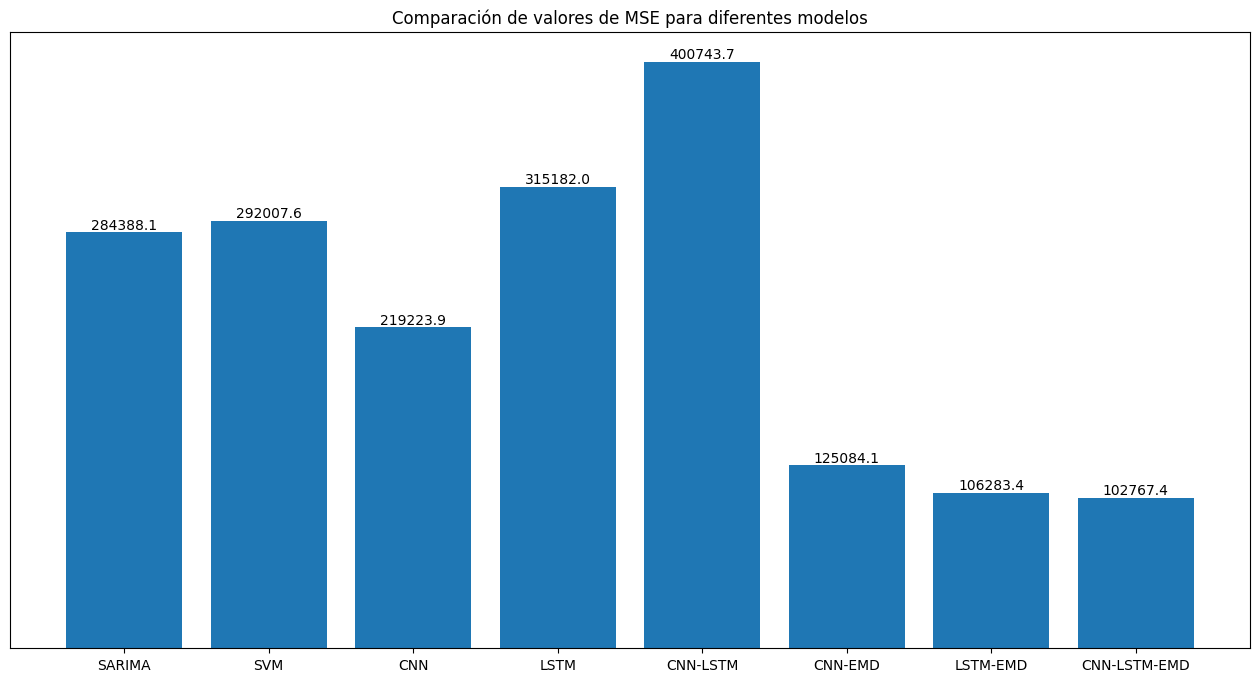

In [ ]:
import matplotlib.pyplot as plt

# Create a list of models and their MSE values
models = ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"]
mse_values = [sarima_mse, svm_mse, cnn_mse, lstm_mse, cnn_lstm_mse, cnn_emd_mse, lstm_emd_mse, cnn_lstm_emd_mse]

# Create the plot
plt.figure(figsize=(16,8))
plt.bar(models, mse_values)
plt.title("Comparación de valores de MSE para diferentes modelos")
plt.gca().set_yticks([])
for i, v in enumerate(mse_values):
    plt.text(i, v, str(round(v, 1)), ha='center', va='bottom')
plt.show()

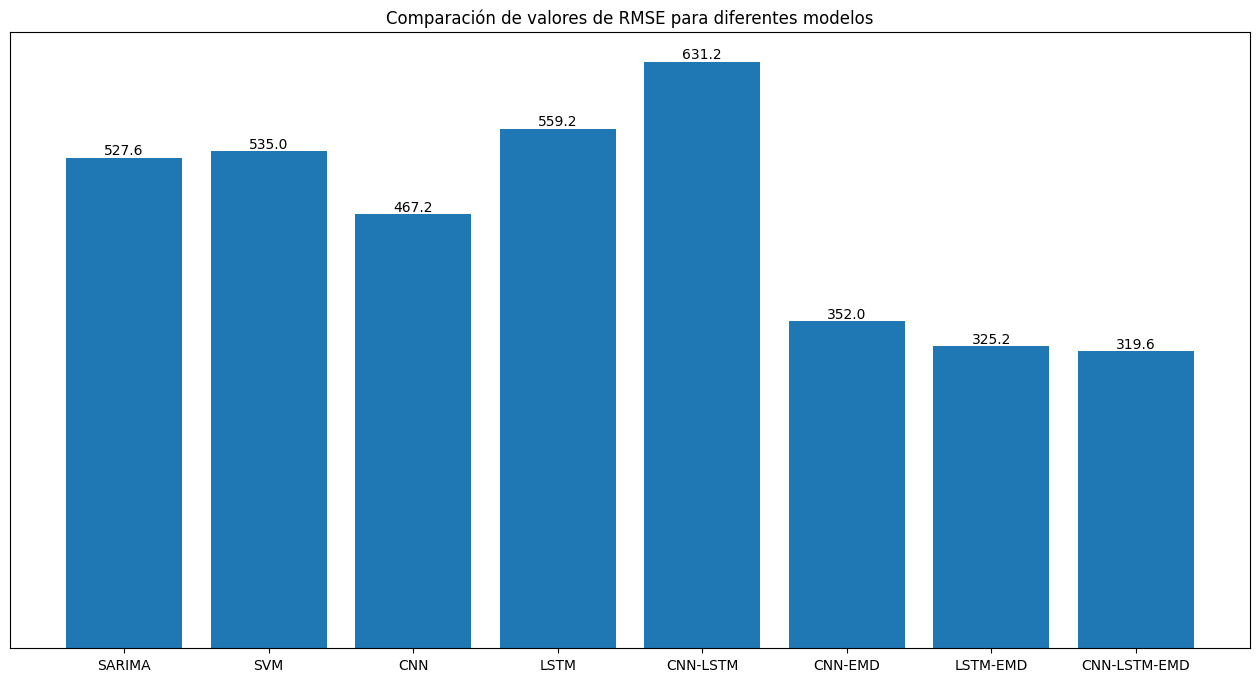

In [ ]:
import matplotlib.pyplot as plt

# Create a list of models and their MSE values
models = ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"]
rmse_values = [sarima_rmse, svm_rmse, cnn_rmse, lstm_rmse, cnn_lstm_rmse, cnn_emd_rmse, lstm_emd_rmse, cnn_lstm_emd_rmse]

# Create the plot
plt.figure(figsize=(16,8))
plt.bar(models, rmse_values)
plt.title("Comparación de valores de RMSE para diferentes modelos")
plt.gca().set_yticks([])
for i, v in enumerate(rmse_values):
    plt.text(i, v, str(round(v, 1)), ha='center', va='bottom')
plt.show()


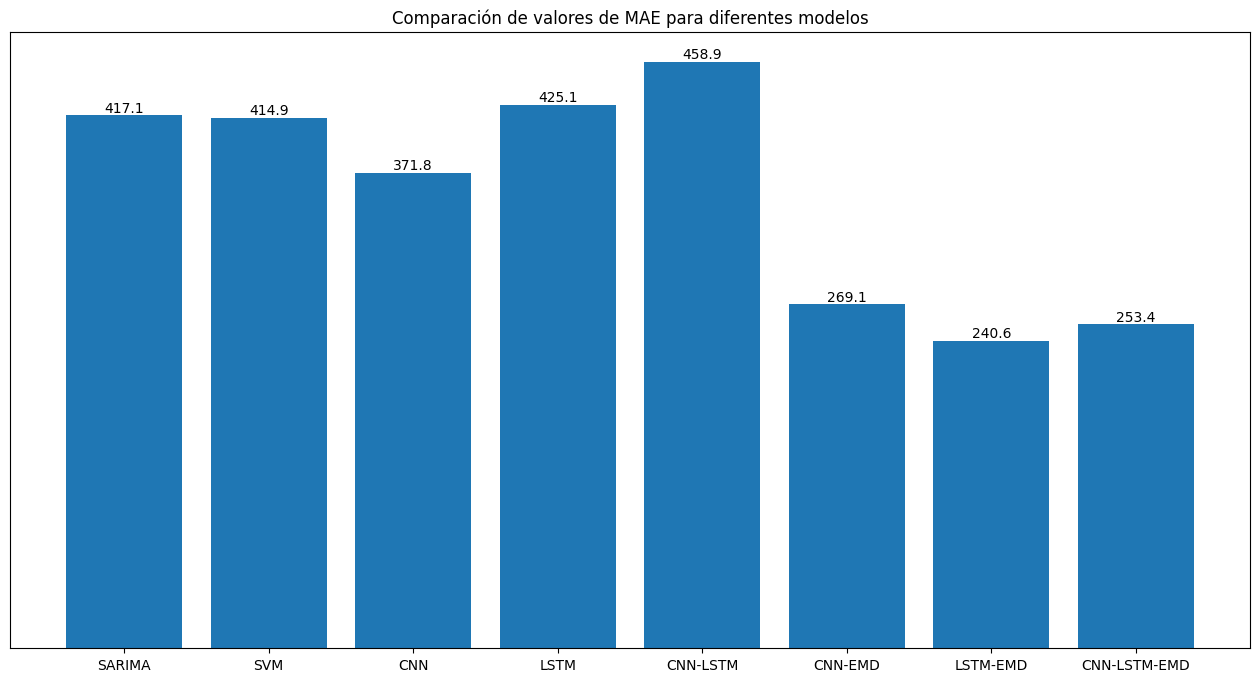

In [ ]:
import matplotlib.pyplot as plt

# Create a list of models and their MSE values
models = ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"]
mae_values = [sarima_mae, svm_mae, cnn_mae, lstm_mae, cnn_lstm_mae, cnn_emd_mae, lstm_emd_mae, cnn_lstm_emd_mae]

# Create the plot
plt.figure(figsize=(16,8))
plt.bar(models, mae_values)
plt.title("Comparación de valores de MAE para diferentes modelos")
plt.gca().set_yticks([])
for i, v in enumerate(mae_values):
    plt.text(i, v, str(round(v, 1)), ha='center', va='bottom')
plt.show()


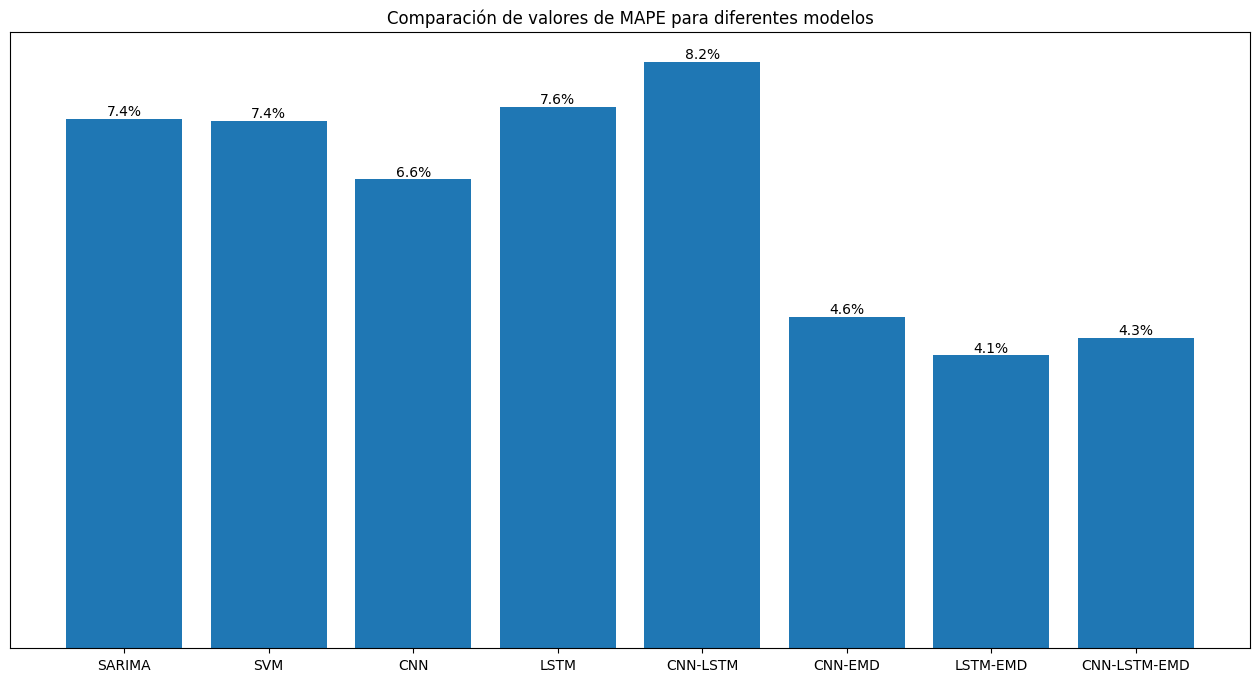

In [ ]:
import matplotlib.pyplot as plt

# Create a list of models and their MSE values
models = ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"]
mape_values = [sarima_mape, svm_mape, cnn_mape, lstm_mape, cnn_lstm_mape, cnn_emd_mape, lstm_emd_mape, cnn_lstm_emd_mape]

# Create the plot
plt.figure(figsize=(16,8))
plt.bar(models, mape_values)
plt.title("Comparación de valores de MAPE para diferentes modelos")
plt.gca().set_yticks([])
for i, v in enumerate(mape_values):
    plt.text(i, v, str(round(v*100, 1)) + '%', ha='center', va='bottom')
plt.show()


Se realiza un t-test

In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors. Test de igualdad de medias. Se informa el estadistico t y el (p valor)
t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mse, list_sarima_mse,equal_var = False)

# Interpret the results.
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y Sarima son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y Sarima no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_rmse, list_sarima_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y Sarima son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y Sarima no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mae, list_sarima_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y Sarima son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y Sarima no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y Sarima son significativamente diferentes.
p-value:  0.0003723365477518097
t-statistic:  -5.835918957428383
Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y Sarima son significativamente diferentes.
p-value:  3.990566657677177e-05
t-statistic:  -7.856453079845998
Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y Sarima son significativamente diferentes.
p-value:  2.6425723230501903e-05
t-statistic:  -7.700340903636657


In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors
t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mse, list_svm_mse,equal_var = False)

# Interpret the results
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y SVM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y SVM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_rmse, list_svm_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y SVM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y SVM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mae, list_svm_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y SVM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y SVM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y SVM son significativamente diferentes.
p-value:  0.00022696204976628253
t-statistic:  -5.834223615496615
Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y SVM son significativamente diferentes.
p-value:  3.8925194204300825e-05
t-statistic:  -6.965168998673028
Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y SVM son significativamente diferentes.
p-value:  0.00012826832703803564
t-statistic:  -6.089264030367009


In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors
t_statistic,p_value = stats.ttest_ind(list_cnn_lstm_emd_mse, list_lstm_emd_mse,equal_var = False)

# Interpret the results
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo CNN-LSTM-EMD y LSTM-EMD son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo CNN-LSTM-EMD y LSTM-EMD no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_cnn_lstm_emd_rmse, list_lstm_emd_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo CNN-LSTM-EMD y LSTM-EMD son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo CNN-LSTM-EMD y LSTM-EMD no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_cnn_lstm_emd_mae, list_lstm_emd_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo CNN-LSTM-EMD y LSTM-EMD son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo CNN-LSTM-EMD y LSTM-EMD no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

No rechazar la hipótesis nula: Los errores MSE del modelo CNN-LSTM-EMD y LSTM-EMD no son significativamente diferentes.
p-value:  0.8673313969211083
t-statistic:  -0.17866442145709027
No rechazar la hipótesis nula: Los errores RMSE del modelo CNN-LSTM-EMD y LSTM-EMD no son significativamente diferentes.
p-value:  0.8521117513150027
t-statistic:  -0.1995610480345553
No rechazar la hipótesis nula: Los errores MAE del modelo CNN-LSTM-EMD y LSTM-EMD no son significativamente diferentes.
p-value:  0.5845109847415619
t-statistic:  -0.5939442169956655


In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors
t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mse, list_cnn_emd_mse,equal_var = False)

# Interpret the results
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN-EMD son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN-EMD no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_rmse, list_cnn_emd_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN-EMD son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN-EMD no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mae, list_cnn_emd_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN-EMD son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN-EMD no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN-EMD no son significativamente diferentes.
p-value:  0.37680202574459287
t-statistic:  -1.028705206972645
No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN-EMD no son significativamente diferentes.
p-value:  0.3942033660881706
t-statistic:  -0.9842261614099708
No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN-EMD no son significativamente diferentes.
p-value:  0.6755655478783327
t-statistic:  -0.45387227926529505


In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors
t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mse, list_cnn_mse,equal_var = False)

# Interpret the results
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_rmse, list_cnn_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mae, list_cnn_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN son significativamente diferentes.
p-value:  1.2041423066328945e-05
t-statistic:  -9.097882252421247
Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN son significativamente diferentes.
p-value:  1.338078236908274e-06
t-statistic:  -11.192663002072907
Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN son significativamente diferentes.
p-value:  1.0004700498101747e-05
t-statistic:  -8.150551737992


In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors
t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mse, list_lstm_mse,equal_var = False)

# Interpret the results
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y LSTM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y LSTM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_rmse, list_lstm_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y LSTM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y LSTM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mae, list_lstm_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y LSTM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y LSTM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y LSTM son significativamente diferentes.
p-value:  1.8136426162425679e-06
t-statistic:  -11.846039071660504
Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y LSTM son significativamente diferentes.
p-value:  1.3883010676657093e-07
t-statistic:  -15.03435992975776
Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y LSTM son significativamente diferentes.
p-value:  9.346672561756374e-07
t-statistic:  -10.873288299563075


In [ ]:
import statistics
import numpy as np
from scipy import stats

# Set the significance level
alpha = 0.05

# Perform a two-sample t-test to compare the standard deviations of the errors
t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mse, list_cnn_lstm_mse,equal_var = False)

# Interpret the results
if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN-LSTM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN-LSTM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_rmse, list_cnn_lstm_rmse,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN-LSTM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN-LSTM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

t_statistic,p_value = stats.ttest_ind(list_lstm_emd_mae, list_cnn_lstm_mae,equal_var = False)

if p_value < alpha:
    print("Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN-LSTM son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)
else:
    print("No rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN-LSTM no son significativamente diferentes.")
    print("p-value: ", p_value)
    print("t-statistic: ", t_statistic)

Rechazar la hipótesis nula: Los errores MSE del modelo LSTM-EMD y CNN-LSTM son significativamente diferentes.
p-value:  6.535979928851628e-07
t-statistic:  -13.5622009116921
Rechazar la hipótesis nula: Los errores RMSE del modelo LSTM-EMD y CNN-LSTM son significativamente diferentes.
p-value:  2.4660233890523356e-08
t-statistic:  -18.285161867089048
Rechazar la hipótesis nula: Los errores MAE del modelo LSTM-EMD y CNN-LSTM son significativamente diferentes.
p-value:  1.819438493437382e-08
t-statistic:  -16.24194458001903


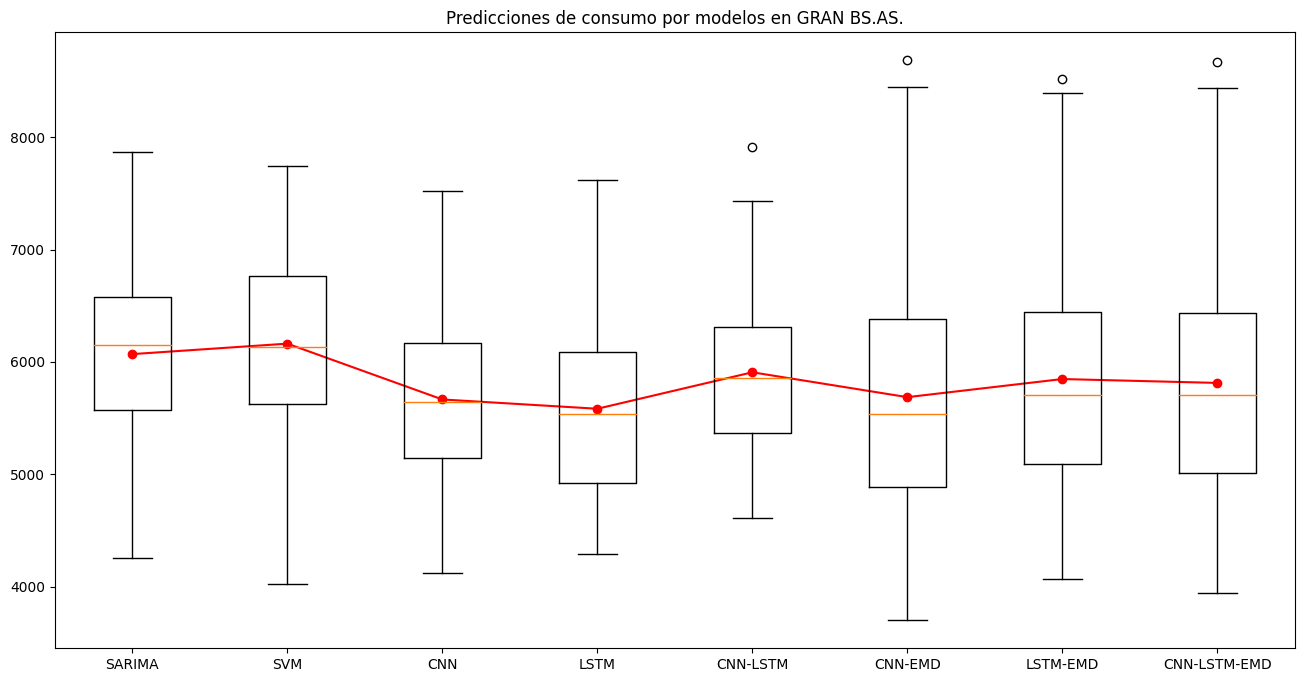

In [ ]:
import matplotlib.pyplot as plt

data=[sarima_pred.values, svm_pred[:, 0], cnn_pred[:, 0], lstm_pred[:, 0], cnn_lstm_pred[:, 0], cnn_emd_pred, lstm_emd_pred, cnn_lstm_emd_pred]

# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar las medias como puntos
ax.plot(range(1, len(means)+1), means, 'ro')

# Conectar las medias con una línea que comienza en un punto específico
start_point = (1, means[0])
x = [start_point[0]] + list(range(1, len(means)+1))
y = [start_point[1]] + means
ax.plot(x, y, 'r-')
ax.figure.set_size_inches(16, 8)

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"])
plt.title("Predicciones de consumo por modelos en GRAN BS.AS.")
plt.show()

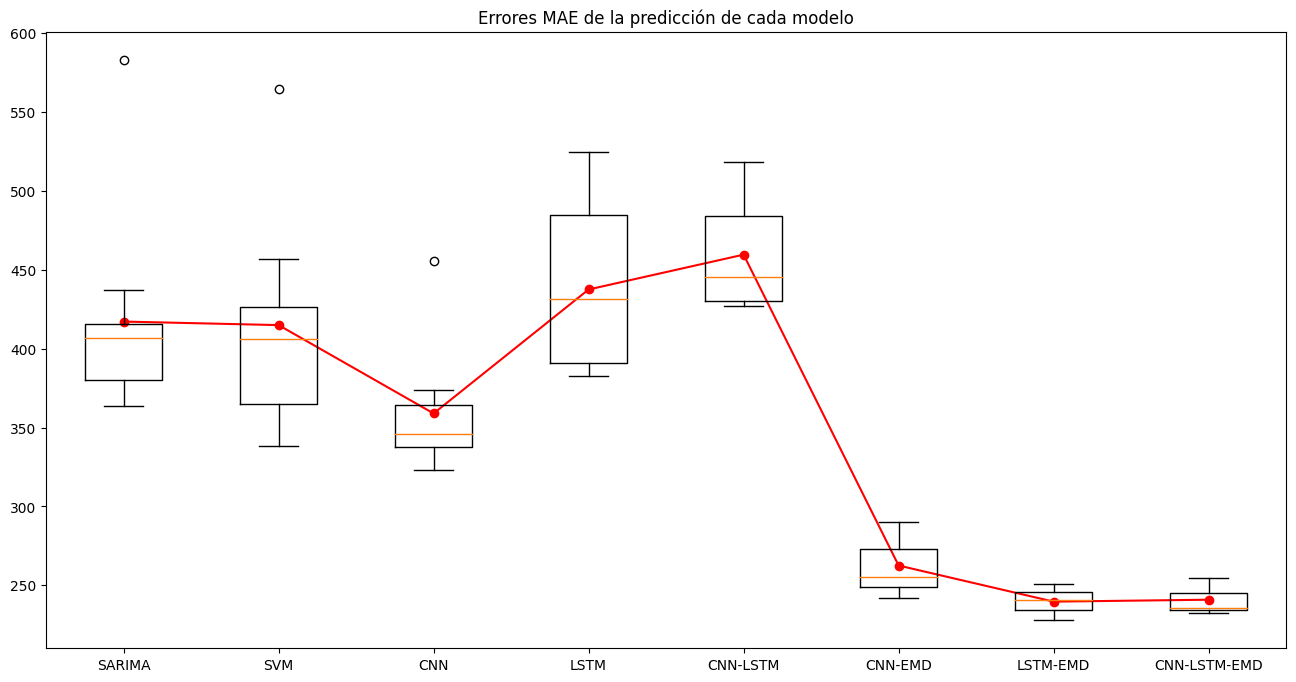

In [ ]:
import matplotlib.pyplot as plt

data=[list_sarima_mae, list_svm_mae, list_cnn_mae, list_lstm_mae, list_cnn_lstm_mae,list_cnn_emd_mae, list_lstm_emd_mae, list_cnn_lstm_emd_mae]

# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar las medias como puntos
ax.plot(range(1, len(means)+1), means, 'ro')

# Conectar las medias con una línea que comienza en un punto específico
start_point = (1, means[0])
x = [start_point[0]] + list(range(1, len(means)+1))
y = [start_point[1]] + means
ax.plot(x, y, 'r-')
ax.figure.set_size_inches(16, 8)

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"])
plt.title("Errores MAE de la predicción de cada modelo")
plt.show()

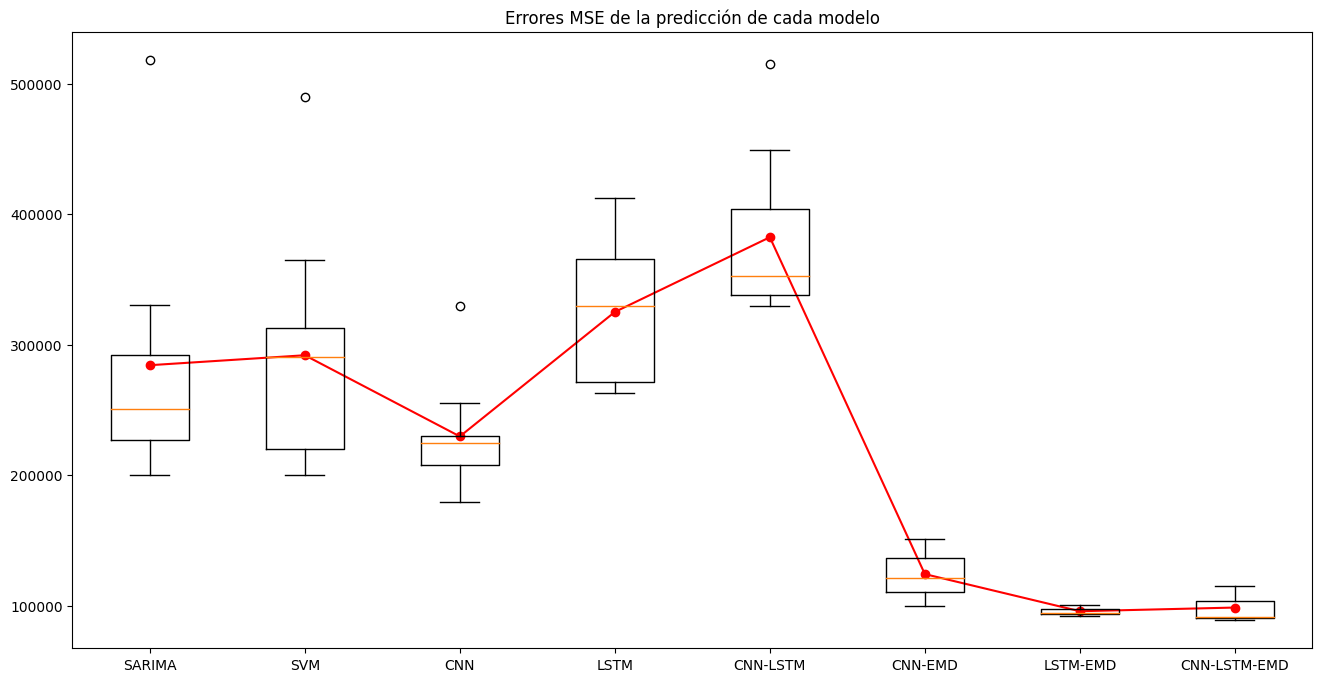

In [ ]:
import matplotlib.pyplot as plt

data=[list_sarima_mse, list_svm_mse, list_cnn_mse, list_lstm_mse, list_cnn_lstm_mse,list_cnn_emd_mse, list_lstm_emd_mse, list_cnn_lstm_emd_mse]

# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar las medias como puntos
ax.plot(range(1, len(means)+1), means, 'ro')

# Conectar las medias con una línea que comienza en un punto específico
start_point = (1, means[0])
x = [start_point[0]] + list(range(1, len(means)+1))
y = [start_point[1]] + means
ax.plot(x, y, 'r-')
ax.figure.set_size_inches(16, 8)

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"])
plt.title("Errores MSE de la predicción de cada modelo")
plt.show()

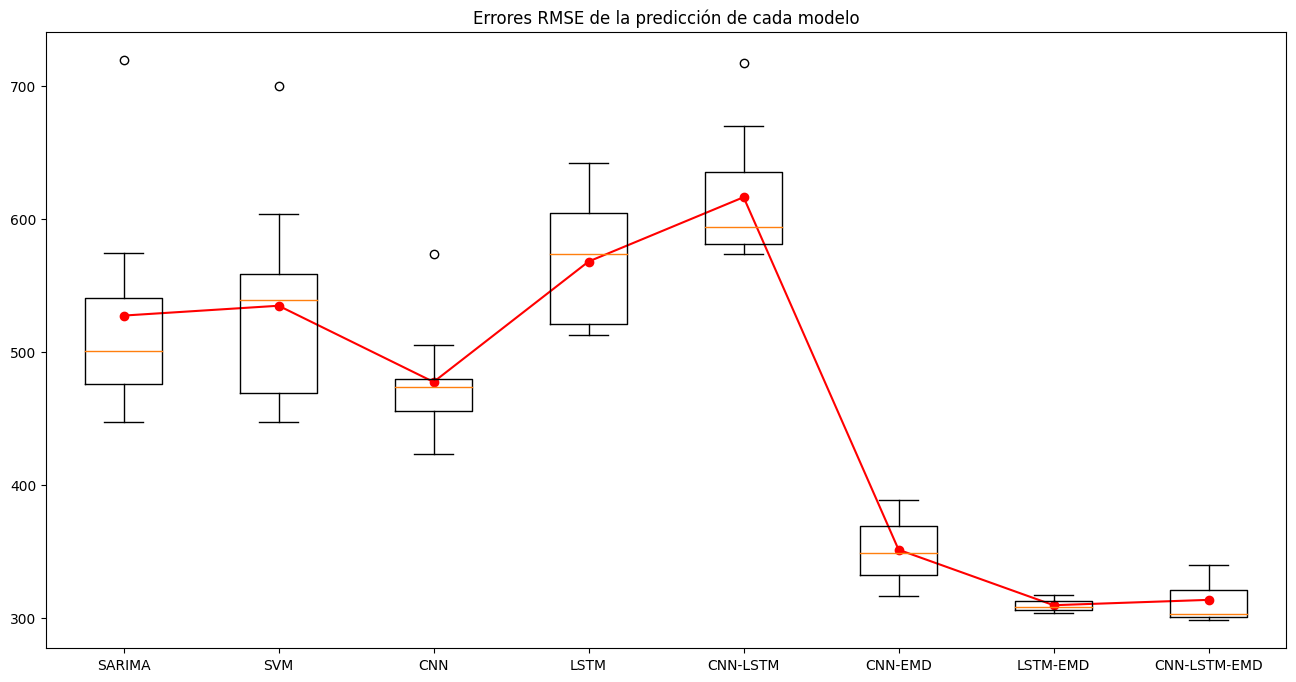

In [ ]:
import matplotlib.pyplot as plt

data=[list_sarima_rmse, list_svm_rmse, list_cnn_rmse, list_lstm_rmse, list_cnn_lstm_rmse,list_cnn_emd_rmse, list_lstm_emd_rmse, list_cnn_lstm_emd_rmse]

# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar las medias como puntos
ax.plot(range(1, len(means)+1), means, 'ro')

# Conectar las medias con una línea que comienza en un punto específico
start_point = (1, means[0])
x = [start_point[0]] + list(range(1, len(means)+1))
y = [start_point[1]] + means
ax.plot(x, y, 'r-')
ax.figure.set_size_inches(16, 8)

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"])
plt.title("Errores RMSE de la predicción de cada modelo")
plt.show()

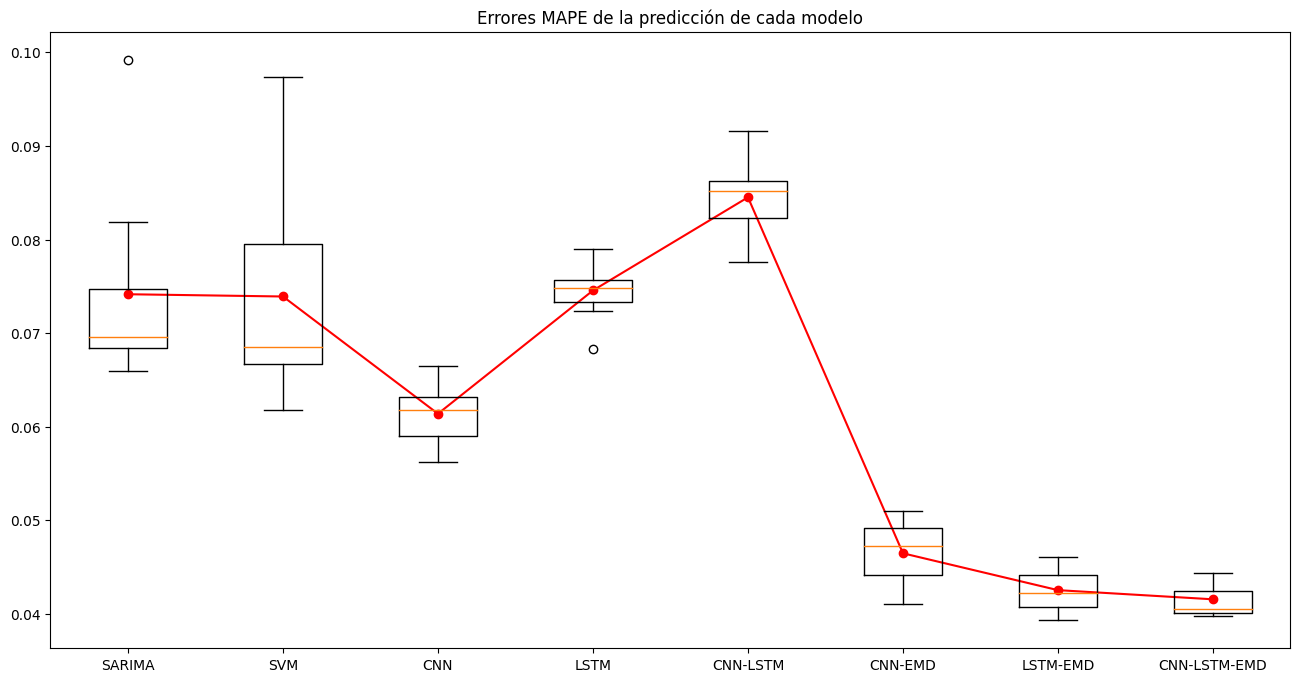

In [ ]:
import matplotlib.pyplot as plt

data=[list_sarima_mape, list_svm_mape, list_cnn_mape, list_lstm_mape, list_cnn_lstm_mape, list_cnn_emd_mape, list_lstm_emd_mape, list_cnn_lstm_emd_mape]

# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar las medias como puntos
ax.plot(range(1, len(means)+1), means, 'ro')

# Conectar las medias con una línea que comienza en un punto específico
start_point = (1, means[0])
x = [start_point[0]] + list(range(1, len(means)+1))
y = [start_point[1]] + means
ax.plot(x, y, 'r-')
ax.figure.set_size_inches(16, 8)

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["SARIMA", "SVM", "CNN", "LSTM", "CNN-LSTM", "CNN-EMD", "LSTM-EMD", "CNN-LSTM-EMD"])
plt.title("Errores MAPE de la predicción de cada modelo")
plt.show()

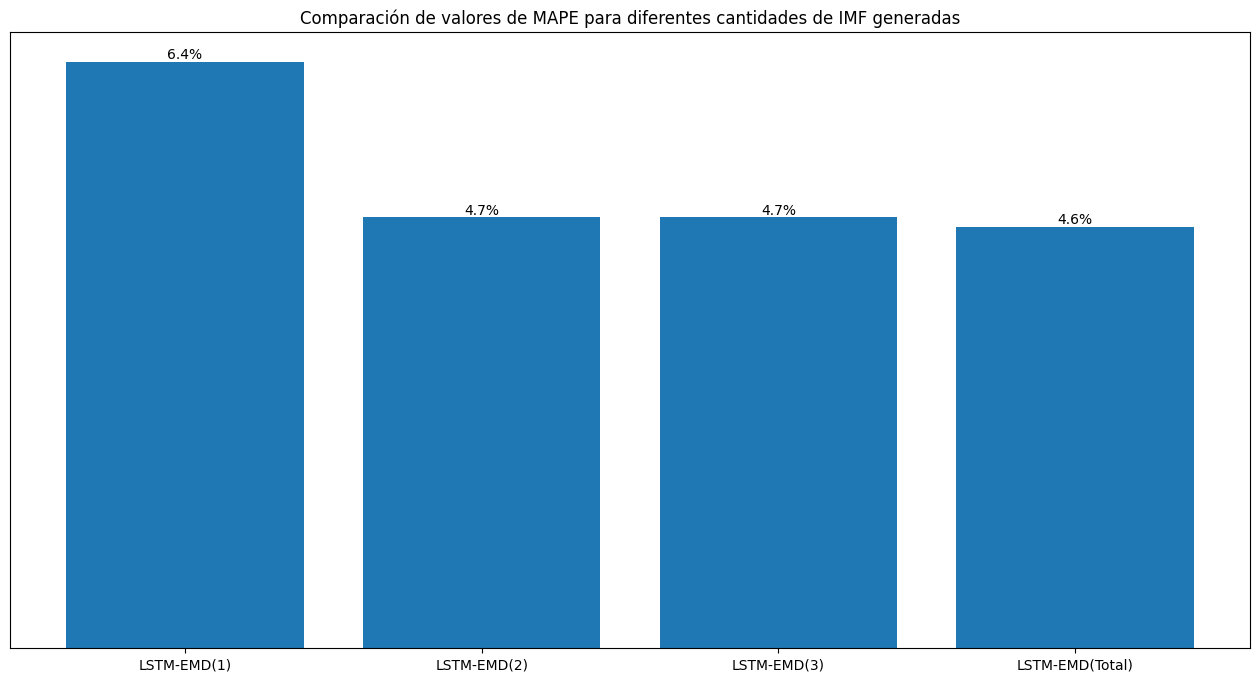

In [ ]:
import matplotlib.pyplot as plt

# Create a list of models and their MSE values
models = ["LSTM-EMD(1)", "LSTM-EMD(2)", "LSTM-EMD(3)", "LSTM-EMD(Total)"]
mape_values = [6.4/100, 4.7/100, 4.7/100, 4.6/100]

# Create the plot
plt.figure(figsize=(16,8))
plt.bar(models, mape_values)
plt.title("Comparación de valores de MAPE para diferentes cantidades de IMF generadas")
plt.gca().set_yticks([])
for i, v in enumerate(mape_values):
    plt.text(i, v, str(round(v*100, 1)) + '%', ha='center', va='bottom')
plt.show()

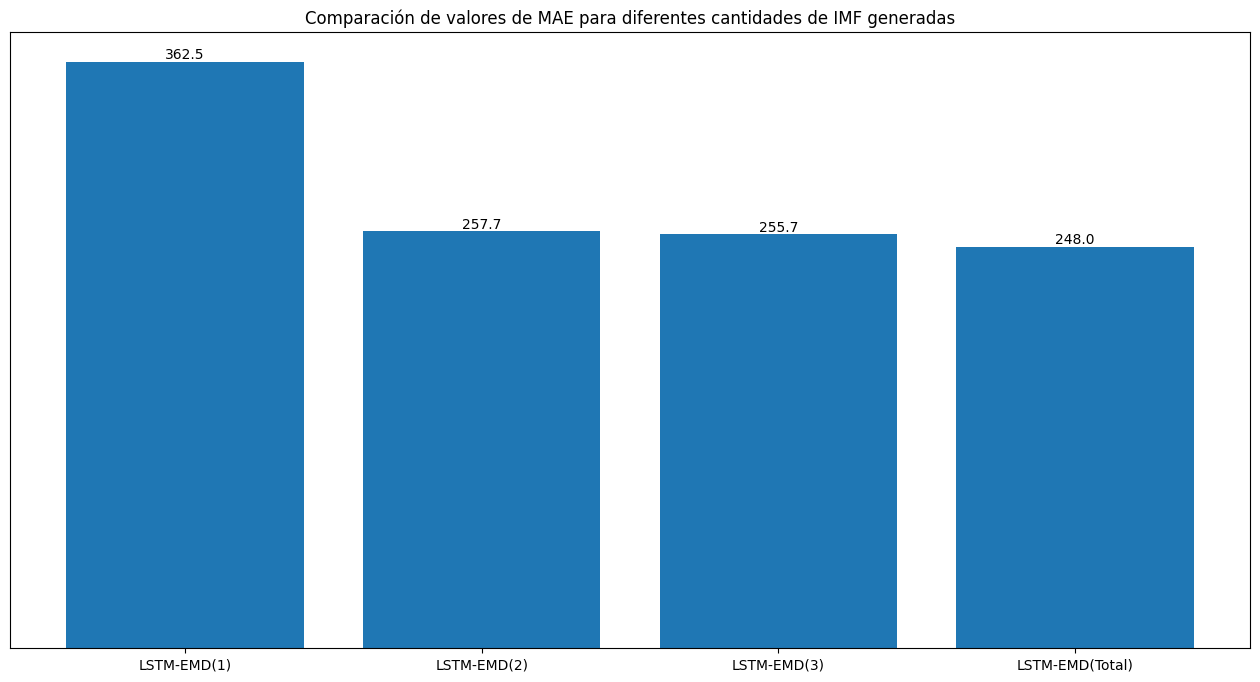

In [ ]:
import matplotlib.pyplot as plt

# Create a list of models and their MSE values
models = ["LSTM-EMD(1)", "LSTM-EMD(2)", "LSTM-EMD(3)", "LSTM-EMD(Total)"]
mae_values = [362.5, 257.7, 255.7, 248.0]

# Create the plot
plt.figure(figsize=(16,8))
plt.bar(models, mae_values)
plt.title("Comparación de valores de MAE para diferentes cantidades de IMF generadas")
plt.gca().set_yticks([])
for i, v in enumerate(mae_values):
    plt.text(i, v, str(round(v, 1)), ha='center', va='bottom')
plt.show()

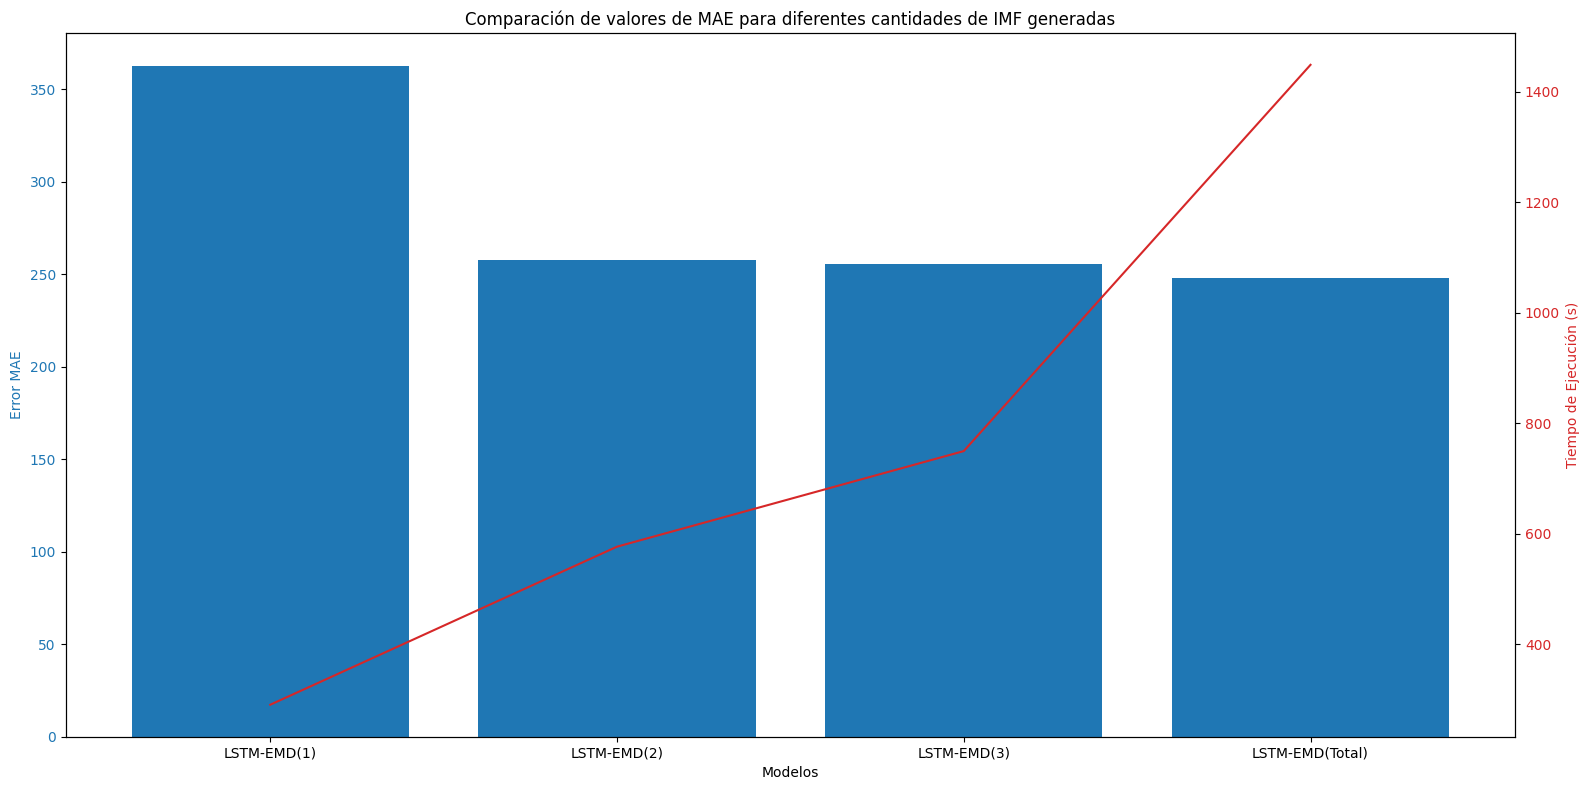

In [ ]:
# prompt: quiero un histograma similar al  anterior pero ademas de ver los errores MAE quiero ver el valor de otra variable, la de tiempo de ejecucion

import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
models = ["LSTM-EMD(1)", "LSTM-EMD(2)", "LSTM-EMD(3)", "LSTM-EMD(Total)"]
mae_values = [362.5, 257.7, 255.7, 248.0]
execution_times = [291, 577, 750, 1449]  # Ejemplo de tiempos de ejecución

# Crear el histograma
fig, ax1 = plt.subplots(figsize=(16, 8))

# Histograma para los errores MAE
color = 'tab:blue'
ax1.set_xlabel('Modelos')
ax1.set_ylabel('Error MAE', color=color)
ax1.bar(models, mae_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje para los tiempos de ejecución
ax2 = ax1.twinx()

# Gráfico de línea para los tiempos de ejecución
color = 'tab:red'
ax2.set_ylabel('Tiempo de Ejecución (s)', color=color)
ax2.plot(models, execution_times, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Título del gráfico
plt.title('Comparación de valores de MAE para diferentes cantidades de IMF generadas')

# Ajustar el diseño y mostrar el gráfico
fig.tight_layout()
plt.show()
